# TD2C-D2C, ideas for different MBs (notebook for comparison)
This notebook wants to compare different formulations of `TD2C` method, each of them with a different way of computing the MB:

MB formulations:

1. **Past MB**: Classic TD2C's MB but considering a bigger lag in the past for the variables under exam. Ex: we want to discoveer the causal path X^(t-1)_i -> X_j and normally we would consider X_i^(t-1), X_i^(t), X_i^(t+1) and X_j^(t-1), X_j^(t), X_j^(t+1) but here we ho back in the past and try to include also  X_i^(t-2), X_i^(t-3), X_i^(t-4) and X_j^(t-2), X_j^(t-3), X_j^(t-4) in X_i and X_j's MBs. 
This is done by setting the `past_lag` parameter in the `D2C` class.

2. **TD2C-D2C MIX**: We combine TD2C's MB with a preliminary ranking of the variables as was done in D2C, trying to reduce the computational cost of D2C and maybe find a better balance for the curse of dimentionality.

3. **MBMB**: D2C's MB but enlarged, including the most relevat variables for the most relevant variables for X_i and X_j.


With this notebook you'll be able to generate the data, generate the decriptors for each of the MB formulations, obtain a classification result and plot the results for comparison.


# Settings

## Packages

In [1]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score

from d2c.data_generation.builder import TSBuilder
from d2c.descriptors_generation import D2C, DataLoader
from d2c.benchmark import D2CWrapper

## Parameters setting

In [2]:
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 2 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = -1 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples

# Data Generation
Data are generated with the `TSBuilder` class and saved in a specific folder. Then, the code checks for missing datasets in the folder and keeps running untill all the possible combinations of parameters have genereted a dataset.

In [11]:
# SET THE TSBUILDER WITH THE DESIRED PARAMETERS
def run_process(params):
    """
    Run a single process of the data generation.
    """
    process, n_variables, max_neighborhood_size, noise_std = params
    try:
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=42, 
                              max_attempts=200,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# BUILD THE DATA
if __name__ == '__main__':
    """
    This script generates the data for different parameters: processes, number of variables, neighborhood sizes and noise levels.
    The data is saved in the .data folder.
    The if __name__ == '__main__': is used to avoid multiprocessing issues in Jupyter notebooks, i.e. the script is run as a script and not
    as a module as it would have been if the script was imported, with the __name__ being the name of the module.
    If the script is imported, the __name__ is the name of the module, if it is run as a script, the __name__ is __main__.
    So, to run this script in a Jupyter notebook, we write the code inside the if __name__ == '__main__': block, while, if we want to import
    the functions from this script, we write "from script import run_process".
    """
    parameters = [(process, n_variables, max_neighborhood_size, noise_std)
                    for process in [1, 2, 3, 4, 6, 7, 8, 9] # , 10, 11, 12, 13, 14, 15, 16, 18, 19, 20
                    for n_variables in [5] # , 10, 25
                    for max_neighborhood_size in [2] # , 4, 8
                    for noise_std in [0.01]] # , 0.005, 0.001

    with Pool(processes=N_JOBS) as pool:
        pool.map(run_process, parameters)


# Function to check for missing files
def check_missing_files():
    missing = []
    for process in [1, 2, 3, 4, 6, 7, 8, 9]:  # , 10, 11, 12, 13, 14, 15, 16, 18, 19, 20
        for n_variables in [5]:  # , 10, 25
            for max_neighborhood_size in [2]:  # , 4, 8
                for noise_std in [0.01]:  # , 0.005, 0.001
                    filename = f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
                    if not os.path.exists(filename):
                        missing.append(filename)
    return missing

# Function to run the process
def run_process(params):
    process, n_variables, max_neighborhood_size, noise_std = params
    try:  # we change the seed and increase the max_attempts
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=24, 
                              max_attempts=400,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# CHECK FOR MISSING FILES (IT CHEKS THE FILES WITH A DIFFERENT SEED AND MORE MAX_ATTEMPTS UNTILL MISSING IS EMPTY)
if __name__ == '__main__':
    while True:
        missing = check_missing_files()
        if not missing:
            break

        parameters = []
        for missing_file in missing:
            process = int(missing_file.split('/')[-1].split('_')[0][1:])
            n_variables = int(missing_file.split('/')[-1].split('_')[1][1:])
            max_neighborhood_size = int(missing_file.split('/')[-1].split('_')[2][2:])
            noise_std = float(missing_file.split('/')[-1].split('_')[3][1:-4])
            parameters.append((process, n_variables, max_neighborhood_size, noise_std))

        with Pool(processes=N_JOBS) as pool:
            pool.map(run_process, parameters)

len(os.listdir('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data'))


P3_N5_Nj2_n0.01 done
P4_N5_Nj2_n0.01 done
P9_N5_Nj2_n0.01 done
P8_N5_Nj2_n0.01 done
P6_N5_Nj2_n0.01 done
P2_N5_Nj2_n0.01 done
P1_N5_Nj2_n0.01 done
P7_N5_Nj2_n0.01 done


18

# Descriptors Generation & Classification

## Regression Estimation of MI

### D2C (& D2C but without contemporaneous nodes) 

#### Descriptors Generation

In [3]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables, maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'original',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [08:11<00:00, 27.28s/it]


#### Run Classifier

In [6]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [7]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_rocs_process = {}
    d2c_precision_process = {}
    d2c_recall_process = {}
    d2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_rocs_process[gen_process_number] = rocs
        d2c_precision_process[gen_process_number] = precisions
        d2c_recall_process[gen_process_number] = recalls
        d2c_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [02:25<00:00,  8.10s/it]


#### Save Results

In [8]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_R_N5.pkl'), 'wb') as f:
    everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

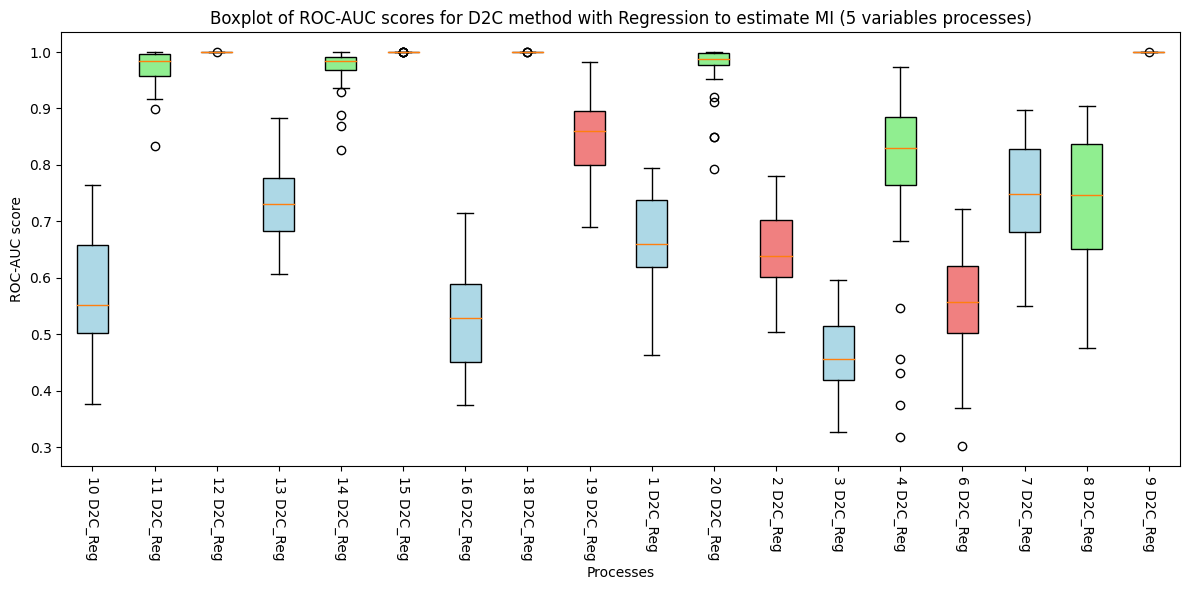

In [9]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_d2c_R_N5.pkl'), 'rb') as f:
    D2C_rocs_process, D2C_precision_process, D2C_recall_process, D2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(D2C_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for D2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C (& TD2C but without contrmporaneous nodes)

#### Descriptors Generation

In [3]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

 56%|█████▌    | 10/18 [02:18<01:57, 14.73s/it]

#### Run Classifier

In [10]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [11]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [02:24<00:00,  8.04s/it]


#### Save Results

In [12]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N10.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N25.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

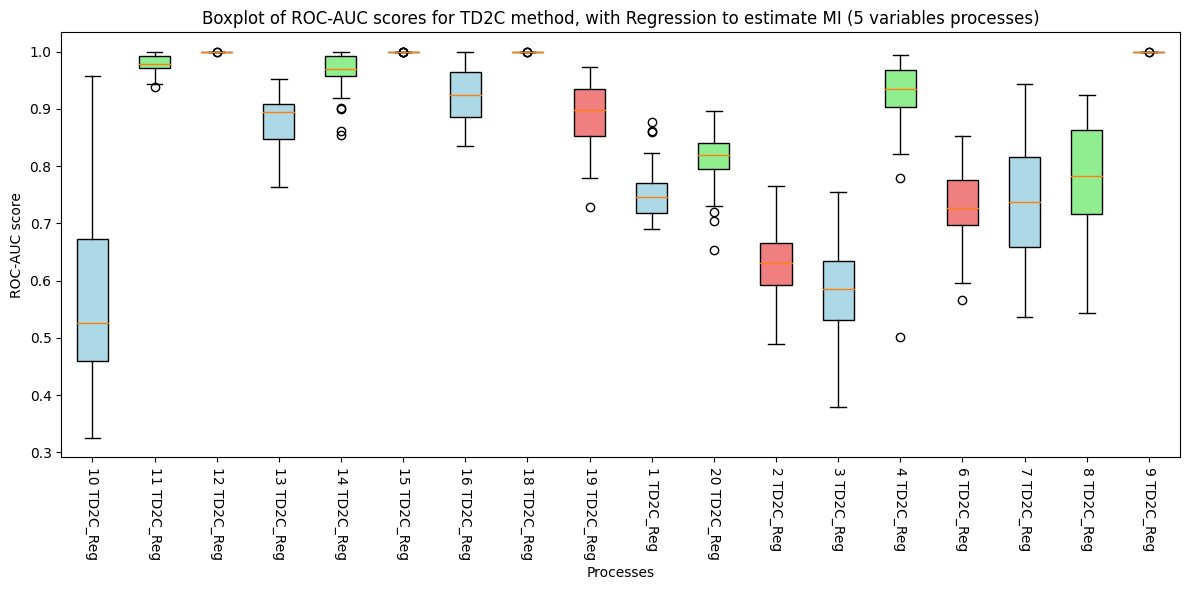

In [13]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process, TD2C_precision_process, TD2C_recall_process, TD2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking (All methods)

#### Descriptors Generation

In [4]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################

# SET FOLDER
cartella = 8
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3, 
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking
# 110 = TD2C_+Ranking_1 with ten variables from ranking
# 5 = TD2C_+Ranking_4 with one variable from ranking
# 6 = TD2C_+Ranking_5 with one variable from ranking
# 7 = TD2C_+Ranking_6 with one variable from ranking
# 8 = TD2C_+Ranking_7 with one variable from ranking

if cartella == 1:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    ts_rank = 'ts_rank'
    vars_to_keep = 1
elif cartella == 11:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 2
elif cartella == 111:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 3
elif cartella == 110:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/10_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 10
elif cartella == 2:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_2/'
    ts_rank = 'ts_rank_2'
    vars_to_keep = 1
elif cartella == 3:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_3/'
    ts_rank = 'ts_rank_3'
    vars_to_keep = 1
elif cartella == 4:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    ts_rank = 'ts_rank_no_cont' 
    vars_to_keep = 1
elif cartella == 5:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_4/'
    ts_rank = 'ts_rank_4' 
    vars_to_keep = 1
elif cartella == 6:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_5/'
    ts_rank = 'ts_rank_5' 
    vars_to_keep = 1
elif cartella == 7:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_6/'
    ts_rank = 'ts_rank_6' 
    vars_to_keep = 1
elif cartella == 8:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_7/'
    ts_rank = 'ts_rank_7' 
    vars_to_keep = 1

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= ts_rank,
            top_vars = vars_to_keep)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [33:36<00:00, 112.02s/it]


#### Run Classifier

In [67]:
cartella = 8

data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []

# TAKES THE FOLDER SET AT THE STEP BEFORE AND RUN ALL THE FOLLOWING CELLS FOR THIS METHOD
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking
# 110 = TD2C_+Ranking_1 with ten variables from ranking
# 5 = TD2C_+Ranking_4 with two variables from ranking
# 6 = TD2C_+Ranking_5 with three variables from ranking

if cartella == 1:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    name = 'TD2C_Ranking_1_1_Var'
elif cartella == 11:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    name = 'TD2C_Ranking_1_2_Var'
elif cartella == 111:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    name = 'TD2C_Ranking_1_3_Var'
elif cartella == 110:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/10_Var/'
    name = 'TD2C_Ranking_1_10_Var'
elif cartella == 2:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_2/'
    name = 'TD2C_Ranking_2'
elif cartella == 3:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_3/'
    name = 'TD2C_Ranking_3'
elif cartella == 4:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    name = 'TD2C_Ranking_NoCont'
elif cartella == 5:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_4/'
    name = 'TD2C_Ranking_4'
elif cartella == 6:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_5/'
    name = 'TD2C_Ranking_5'
elif cartella == 7:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_6/'
    name = 'TD2C_Ranking_6'
elif cartella == 8:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_7/'
    name = 'TD2C_Ranking_7'



# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [68]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file


for n_vars, todo in todos.items():
    m1 = f'{name}_rocs_process'
    m2 = f'{name}_precision_process'
    m3 = f'{name}_recall_process'
    m4 = f'{name}_f1_process'

    globals()[m1] = {}
    globals()[m2] = {}
    globals()[m3] = {}
    globals()[m4] = {}


    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        globals()[m1][gen_process_number] = rocs
        globals()[m2][gen_process_number] = precisions
        globals()[m3][gen_process_number] = recalls
        globals()[m4][gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [02:25<00:00,  8.08s/it]


#### Save Results

In [69]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_{name}_N5.pkl'), 'wb') as f:
    everything = (globals()[m1], globals()[m2], globals()[m3], globals()[m4])
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Load data for local and global plots

##### local save

In [70]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# LOCAL
with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
    globals()[m1], globals()[m2], globals()[m3], globals()[m4] = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

##### global save

In [71]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

cartella = 8

if cartella == 1:
    name = 'TD2C_Ranking_1_1_Var'
elif cartella == 11:
    name = 'TD2C_Ranking_1_2_Var'
elif cartella == 111:
    name = 'TD2C_Ranking_1_3_Var'
elif cartella == 110:
    name = 'TD2C_Ranking_1_10_Var'
elif cartella == 2:
    name = 'TD2C_Ranking_2'
elif cartella == 3:
    name = 'TD2C_Ranking_3'
elif cartella == 4:
    name = 'TD2C_Ranking_NoCont'
elif cartella == 5:
    name = 'TD2C_Ranking_4'
elif cartella == 6:
    name = 'TD2C_Ranking_5'
elif cartella == 7:
    name = 'TD2C_Ranking_6'
elif cartella == 8:
    name = 'TD2C_Ranking_7'

if cartella == 1:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_1_Var_rocs_process, TD2C_Ranking_1_1_Var_precision_process, TD2C_Ranking_1_1_Var_recall_process, TD2C_Ranking_1_1_Var_f1_process = pickle.load(f)
elif cartella == 11:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_2_Var_rocs_process, TD2C_Ranking_1_2_Var_precision_process, TD2C_Ranking_1_2_Var_recall_process, TD2C_Ranking_1_2_Var_f1_process = pickle.load(f)
elif cartella == 111:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_3_Var_rocs_process, TD2C_Ranking_1_3_Var_precision_process, TD2C_Ranking_1_3_Var_recall_process, TD2C_Ranking_1_3_Var_f1_process = pickle.load(f)
elif cartella == 110:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_10_Var_rocs_process, TD2C_Ranking_1_10_Var_precision_process, TD2C_Ranking_1_10_Var_recall_process, TD2C_Ranking_1_10_Var_f1_process = pickle.load(f)
elif cartella == 2:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_2_rocs_process, TD2C_Ranking_2_precision_process, TD2C_Ranking_2_recall_process, TD2C_Ranking_2_f1_process = pickle.load(f)
elif cartella == 3:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_3_rocs_process, TD2C_Ranking_3_precision_process, TD2C_Ranking_3_recall_process, TD2C_Ranking_3_f1_process = pickle.load(f)
elif cartella == 4:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_NoCont_rocs_process, TD2C_Ranking_NoCont_precision_process, TD2C_Ranking_NoCont_recall_process, TD2C_Ranking_NoCont_f1_process = pickle.load(f)
elif cartella == 5:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_4_rocs_process, TD2C_Ranking_4_precision_process, TD2C_Ranking_4_recall_process, TD2C_Ranking_4_f1_process = pickle.load(f)
elif cartella == 6:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_5_rocs_process, TD2C_Ranking_5_precision_process, TD2C_Ranking_5_recall_process, TD2C_Ranking_5_f1_process = pickle.load(f)
elif cartella == 7:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_6_rocs_process, TD2C_Ranking_6_precision_process, TD2C_Ranking_6_recall_process, TD2C_Ranking_6_f1_process = pickle.load(f)
elif cartella == 8:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_7_rocs_process, TD2C_Ranking_7_precision_process, TD2C_Ranking_7_recall_process, TD2C_Ranking_7_f1_process = pickle.load(f)

#### Plot

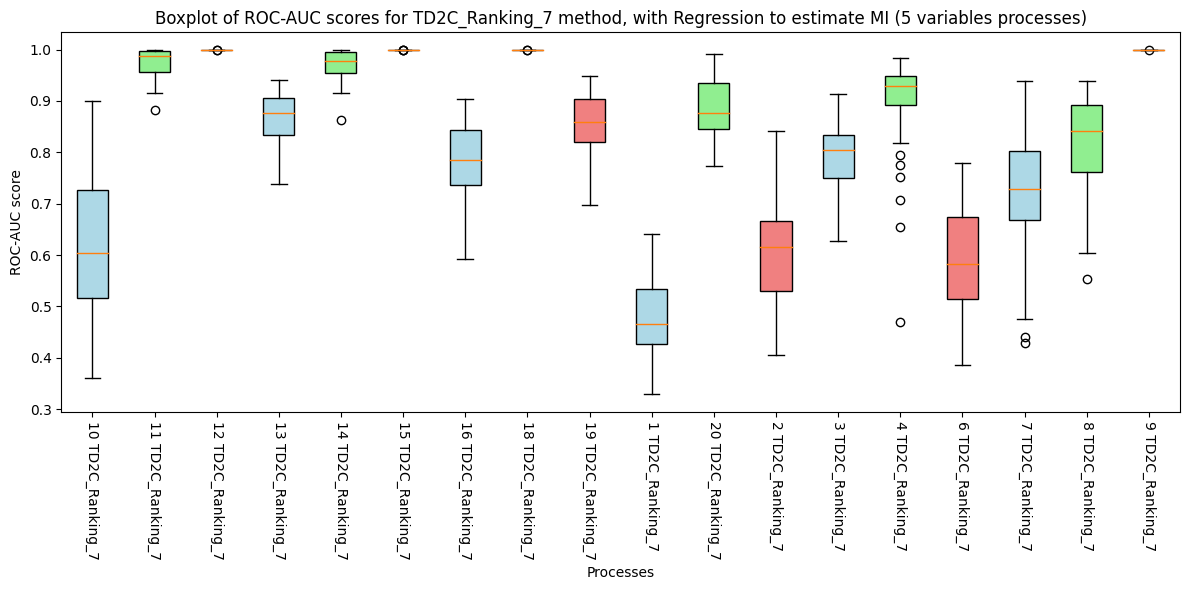

In [72]:
df1 = pd.DataFrame(globals()[m1])
df_name = f'{name}_rocs_dataset'
globals()[df_name] = df1

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} {name}')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title(f'Boxplot of ROC-AUC scores for {name} method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past-future (& TD2C in the past-future but without contrmporaneous nodes)

#### Descriptors Generation

In [5]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_PastFut/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts_past')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [15:13<00:00, 50.76s/it]


#### Run Classifier

In [14]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_PastFut/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [15]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_rocs_process = {}
    td2c_past_precision_process = {}
    td2c_past_recall_process = {}
    td2c_past_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_rocs_process[gen_process_number] = rocs
        td2c_past_precision_process[gen_process_number] = precisions
        td2c_past_recall_process[gen_process_number] = recalls
        td2c_past_f1_process[gen_process_number] = f1s

100%|██████████| 18/18 [02:24<00:00,  8.04s/it]


#### Save Results

In [17]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_R_N5.pkl'), 'wb') as f:
    everything = (td2c_past_rocs_process, td2c_past_precision_process, td2c_past_recall_process, td2c_past_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

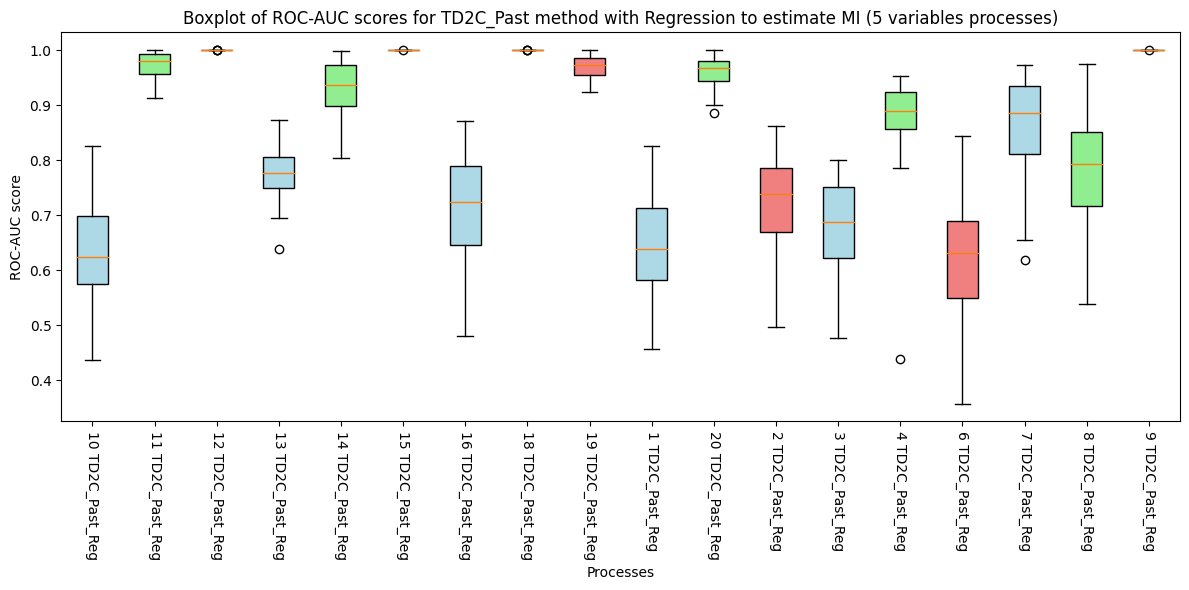

In [18]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    TD2C_Ranking_PastFut_rocs_process, TD2C_Ranking_PastFut_precision_process, TD2C_Ranking_PastFut_recall_process, TD2C_Ranking_PastFut_f1_process = pickle.load(f) 

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Past_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_Past method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

# Plot all Results - Comparison

## Regression for MI estimation

### ROC-AUC

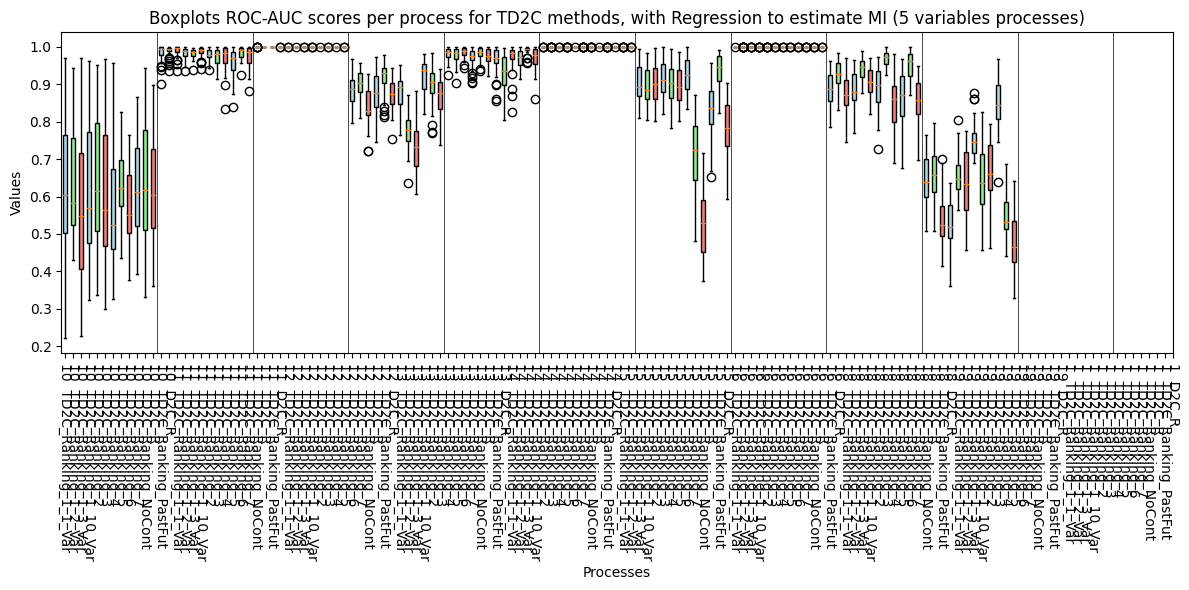

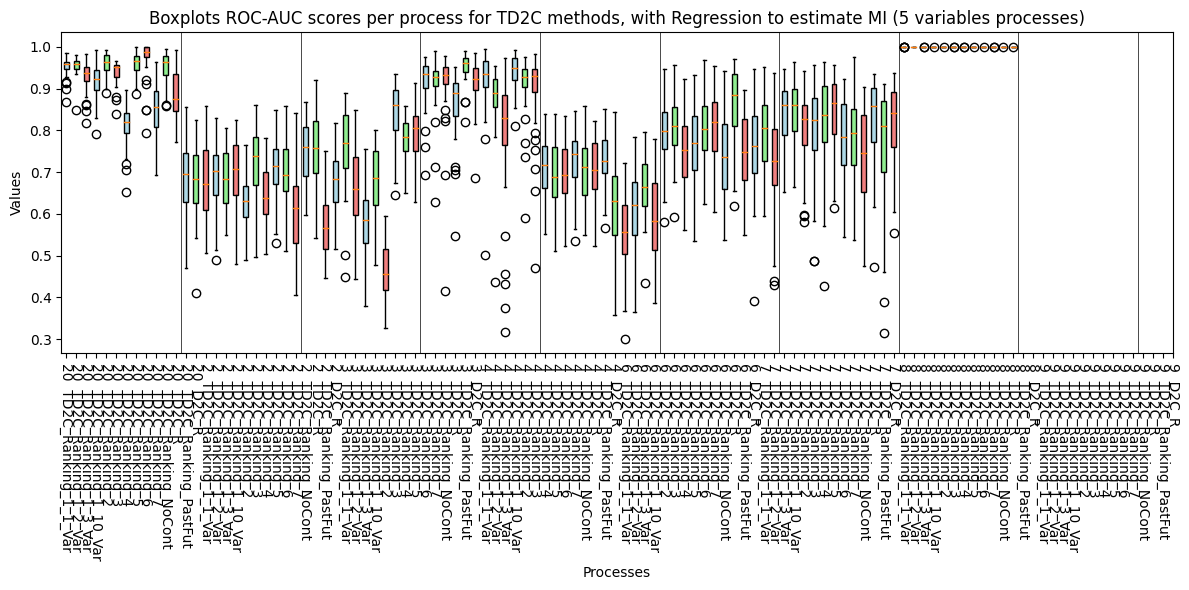

In [73]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplots ROC-AUC scores per process for TD2C methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplots ROC-AUC scores per process for TD2C methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

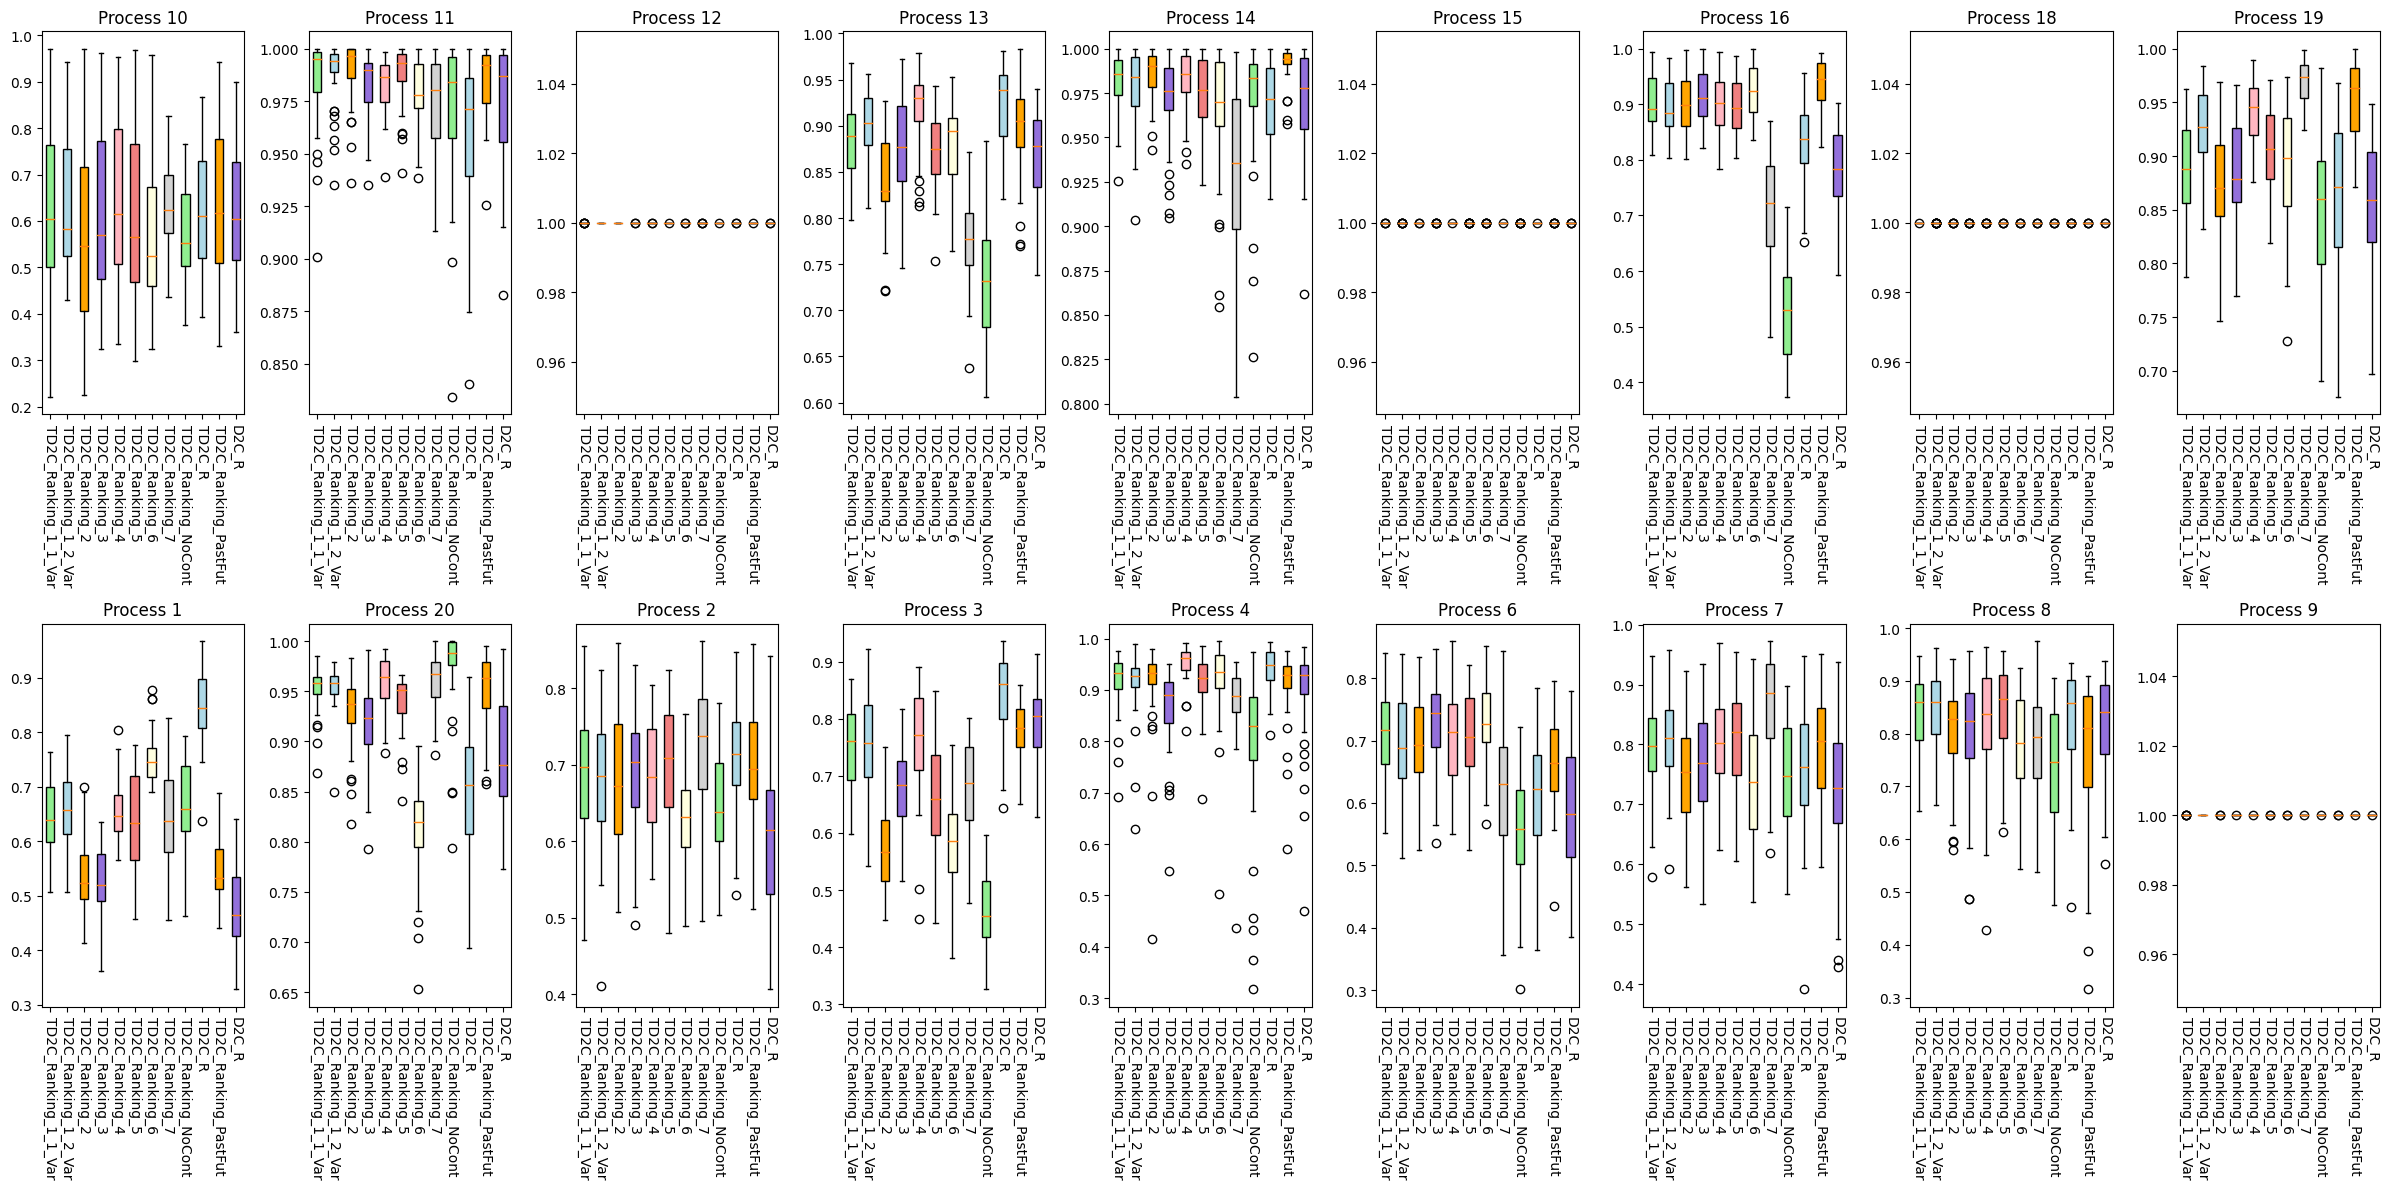

In [74]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocouc_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



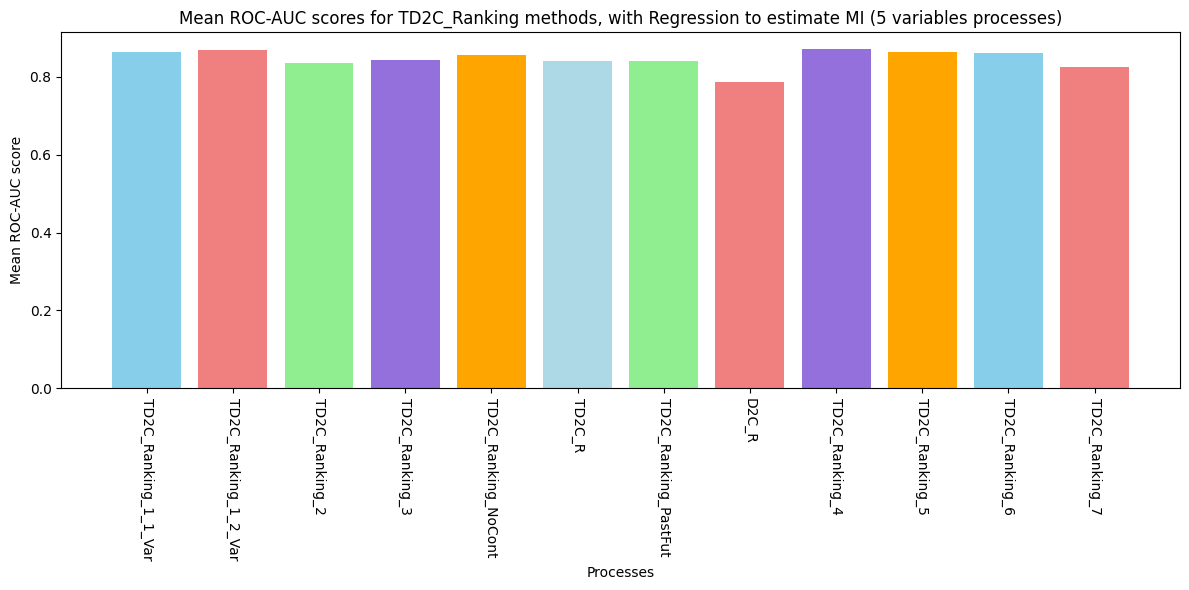

In [75]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean ROC-AUC score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [76]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='roc_auc')

df['roc_auc'] = df['roc_auc'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='roc_auc')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_rocs_process': 'TD2C_+Ranking_1_1_Var_rocs_process', 
                        'TD2C_+Ranking_1_2_Var_rocs_process': 'TD2C_+Ranking_1_2_Var_rocs_process', 
                        # 'TD2C_+Ranking_1_3_Var_rocs_process': 'TD2C_+Ranking_1_3_Var_rocs_process',
                        # 'TD2C_+Ranking_1_10_Var_rocs_process': 'TD2C_+Ranking_1_10_Var_rocs_process', 
                        'TD2C_+Ranking_2_rocs_process': 'TD2C_+Ranking_2_rocs_process', 
                        'TD2C_+Ranking_3_rocs_process': 'TD2C_+Ranking_3_rocs_process',
                        'TD2C_+Ranking_4_rocs_process': 'TD2C_+Ranking_4_rocs_process', 
                        'TD2C_+Ranking_NoCont_rocs_process': 'TD2C_+Ranking_NoCont_rocs_process',
                        'TD2C_R_rocs_process': 'TD2C_R_rocs_process',
                        'TD2C_+Ranking_PastFut_rocs_process': 'TD2C_+Ranking_PastFut_rocs_process',
                        'D2C_R_rocs_process': 'D2C_R_rocs_process'})

# eliminate the column method and make the process_id the index of the dataframe



# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv', index=False)

df

method  Process ID     D2C_R    TD2C_R  TD2C_Ranking_1_1_Var  \
0                1  0.666210  0.753646              0.646072   
1                2  0.641647  0.629342              0.693840   
2                3  0.463526  0.575214              0.753111   
3                4  0.786306  0.917123              0.916907   
4                6  0.558760  0.731471              0.710081   
5                7  0.749723  0.726939              0.795418   
6                8  0.728986  0.780795              0.839310   
7                9  1.000000  1.000000              1.000000   
8               10  0.568306  0.571203              0.620676   
9               11  0.972074  0.978363              0.984951   
10              12  1.000000  1.000000              1.000000   
11              13  0.732684  0.880450              0.884478   
12              14  0.970627  0.964388              0.981269   
13              15  1.000000  1.000000              1.000000   
14              16  0.526021  0.918926              0.902353   
15              18  1.000000  1.000000              1.000000   
16              19  0.846981  0.889260              0.884516   
17              20  0.972286  0.810795              0.953043   

method  TD2C_Ranking_1_2_Var  TD2C_Ranking_2  TD2C_Ranking_3  TD2C_Ranking_4  \
0                   0.664176        0.538217        0.522469        0.657247   
1                   0.681191        0.679353        0.688337        0.684934   
2                   0.749296        0.570243        0.680644        0.756748   
3                   0.914307        0.909063        0.864957        0.952433   
4                   0.694848        0.696152        0.729594        0.706455   
5                   0.804635        0.750985        0.762450        0.800596   
6                   0.843806        0.804521        0.800139        0.811185   
7                   1.000000        1.000000        1.000000        1.000000   
8                   0.633175        0.559275        0.610524        0.632079   
9                   0.988360        0.989789        0.983123        0.982740   
10                  1.000000        1.000000        1.000000        1.000000   
11                  0.901593        0.840297        0.875176        0.918212   
12                  0.977838        0.985476        0.970963        0.981777   
13                  1.000000        1.000000        1.000000        1.000000   
14                  0.897188        0.904335        0.913046        0.893856   
15                  1.000000        1.000000        1.000000        1.000000   
16                  0.922899        0.871663        0.886556        0.943645   
17                  0.955027        0.928297        0.917416        0.957402   

method  TD2C_Ranking_5  TD2C_Ranking_6  TD2C_Ranking_7  TD2C_Ranking_NoCont  \
0             0.847458        0.550302        0.476962             0.638998   
1             0.712065        0.699074        0.602773             0.693667   
2             0.839952        0.774004        0.787110             0.660651   
3             0.939714        0.910610        0.892681             0.914152   
4             0.615183        0.668085        0.593913             0.702446   
5             0.759699        0.788687        0.725282             0.811124   
6             0.821252        0.765276        0.817418             0.838153   
7             1.000000        1.000000        1.000000             1.000000   
8             0.628455        0.635760        0.616514             0.594395   
9             0.958102        0.984858        0.973167             0.987634   
10            1.000000        1.000000        1.000000             1.000000   
11            0.920350        0.895206        0.864997             0.872676   
12            0.969034        0.991781        0.969246             0.974921   
13            1.000000        1.000000        1.000000             1.000000   
14            0.833782        0.935624        0.785059             0.899751  

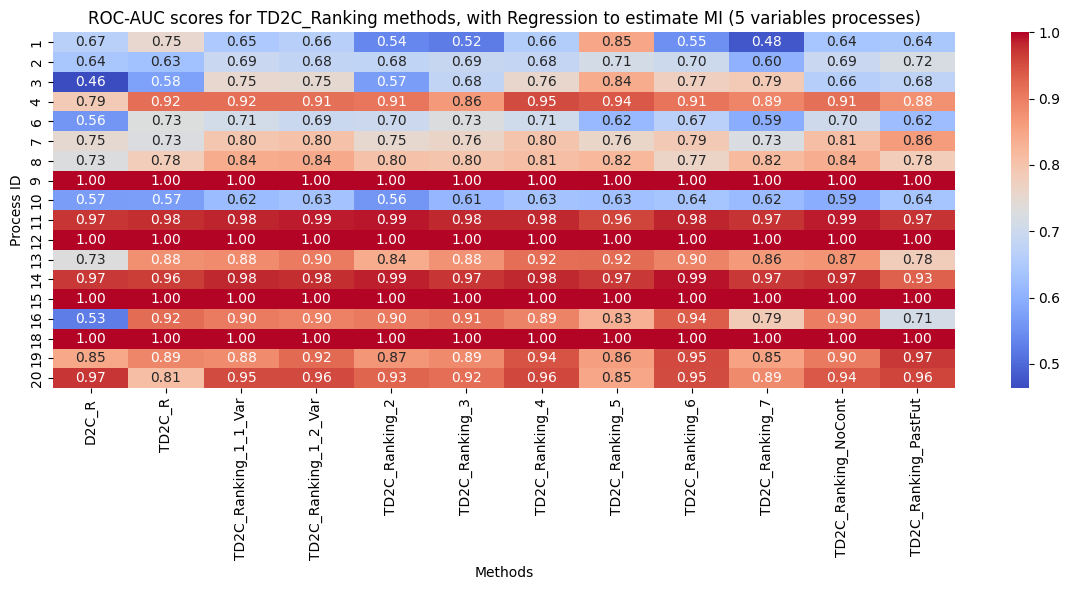

In [77]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_heatmap_TD2C_Ranking.pdf')

plt.show()

In [78]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'roc_auc'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_mean_proc.csv', index=False)

df

Process ID   roc_auc
0            1  0.633854
1            2  0.677121
2            3  0.690616
3            4  0.899703
4            6  0.669106
5            7  0.778212
6            8  0.802617
7            9  1.000000
8           10  0.608836
9           11  0.979688
10          12  1.000000
11          13  0.863672
12          14  0.972413
13          15  1.000000
14          16  0.843544
15          18  1.000000
16          19  0.899020
17          20  0.923384

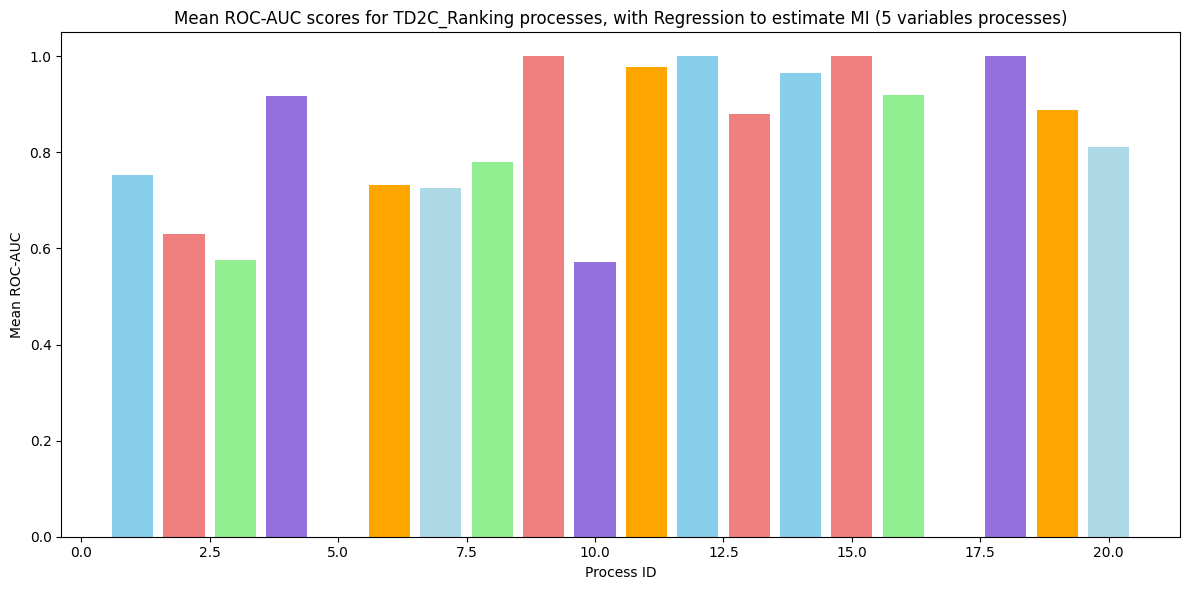

In [79]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean ROC-AUC scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [80]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'roc_auc'})

df = df.sort_values(by='roc_auc', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv', index=False)

df

method   roc_auc
1         TD2C_Ranking_4  0.871073
2   TD2C_Ranking_1_2_Var  0.868241
3   TD2C_Ranking_1_1_Var  0.864779
4         TD2C_Ranking_5  0.864029
5         TD2C_Ranking_6  0.861450
6    TD2C_Ranking_NoCont  0.857416
7         TD2C_Ranking_3  0.844744
8   TD2C_Ranking_PastFut  0.841383
9                 TD2C_R  0.840440
10        TD2C_Ranking_2  0.834870
11        TD2C_Ranking_7  0.824758
12                 D2C_R  0.788008

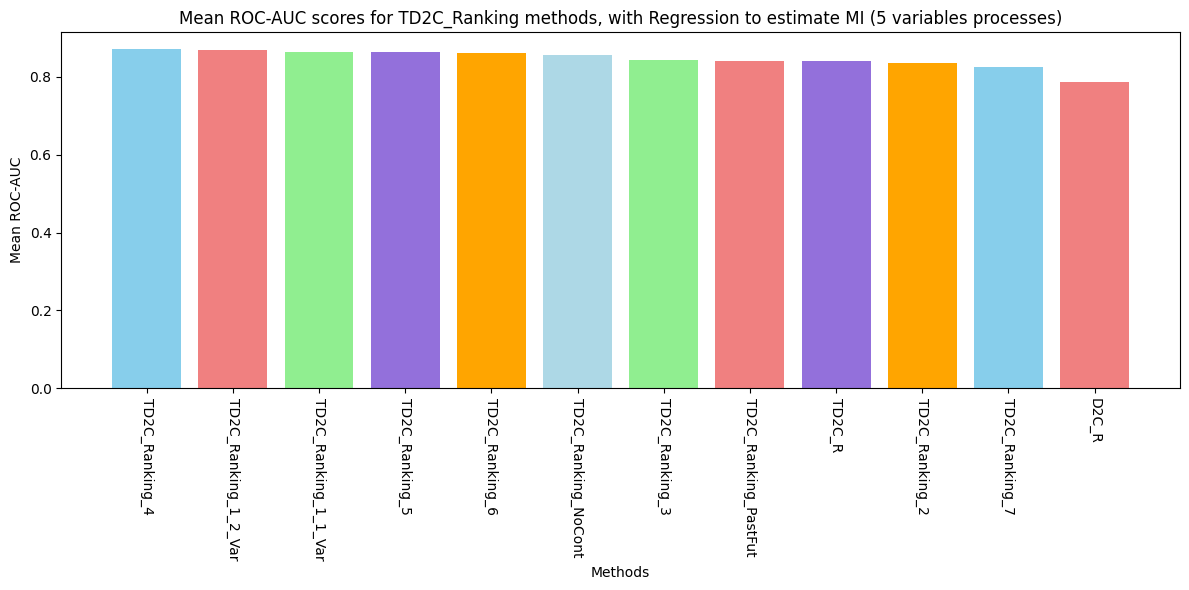

In [83]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['roc_auc'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### Precision

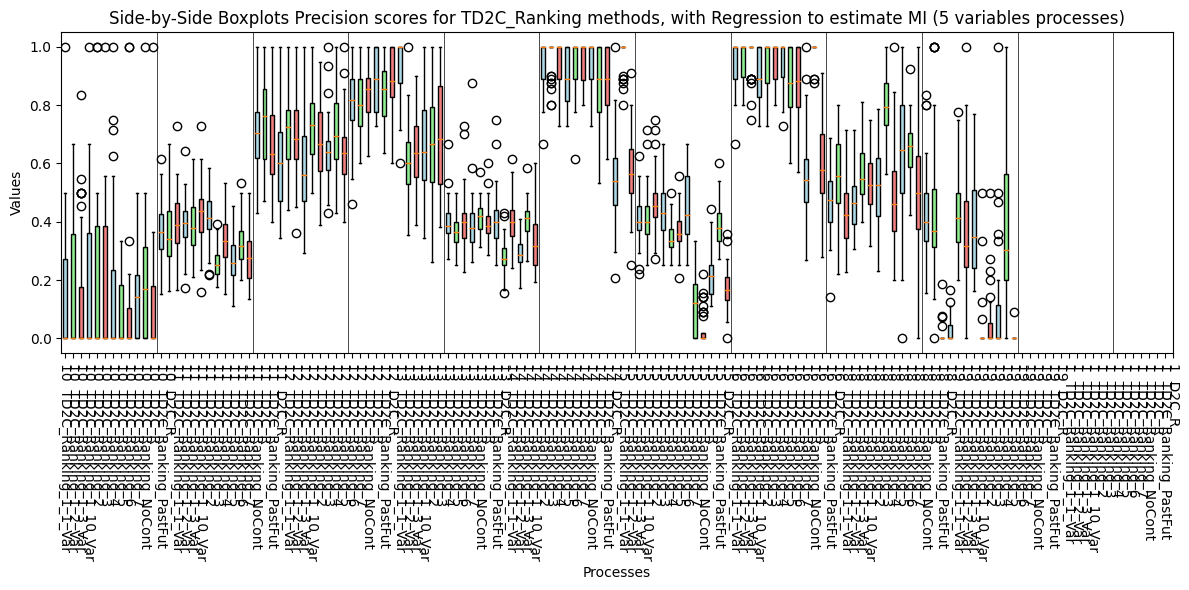

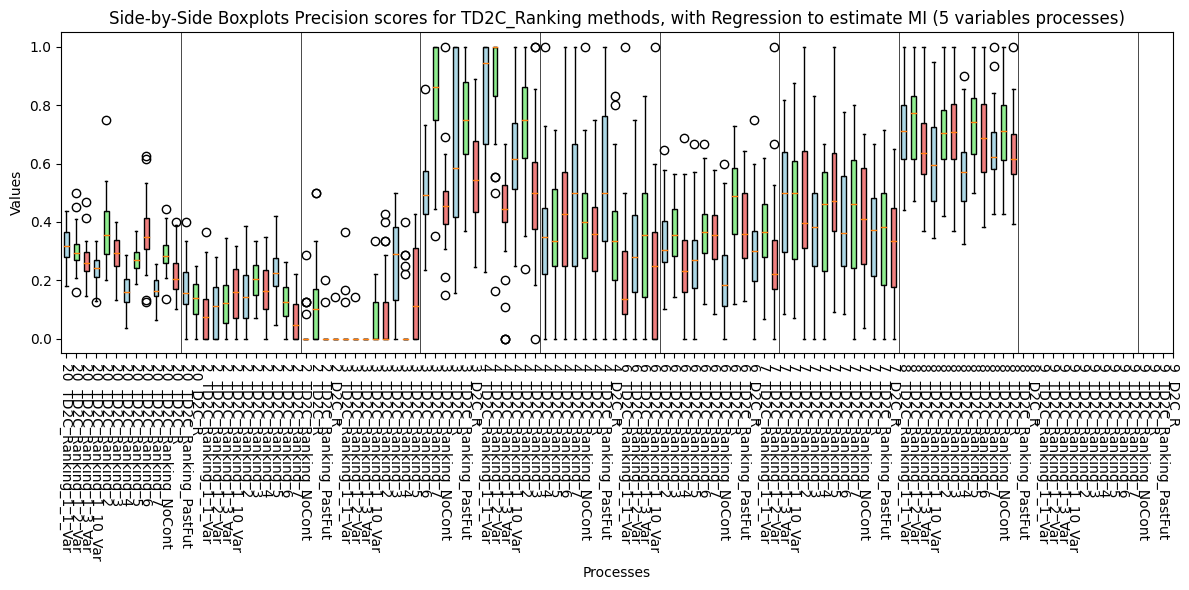

In [86]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

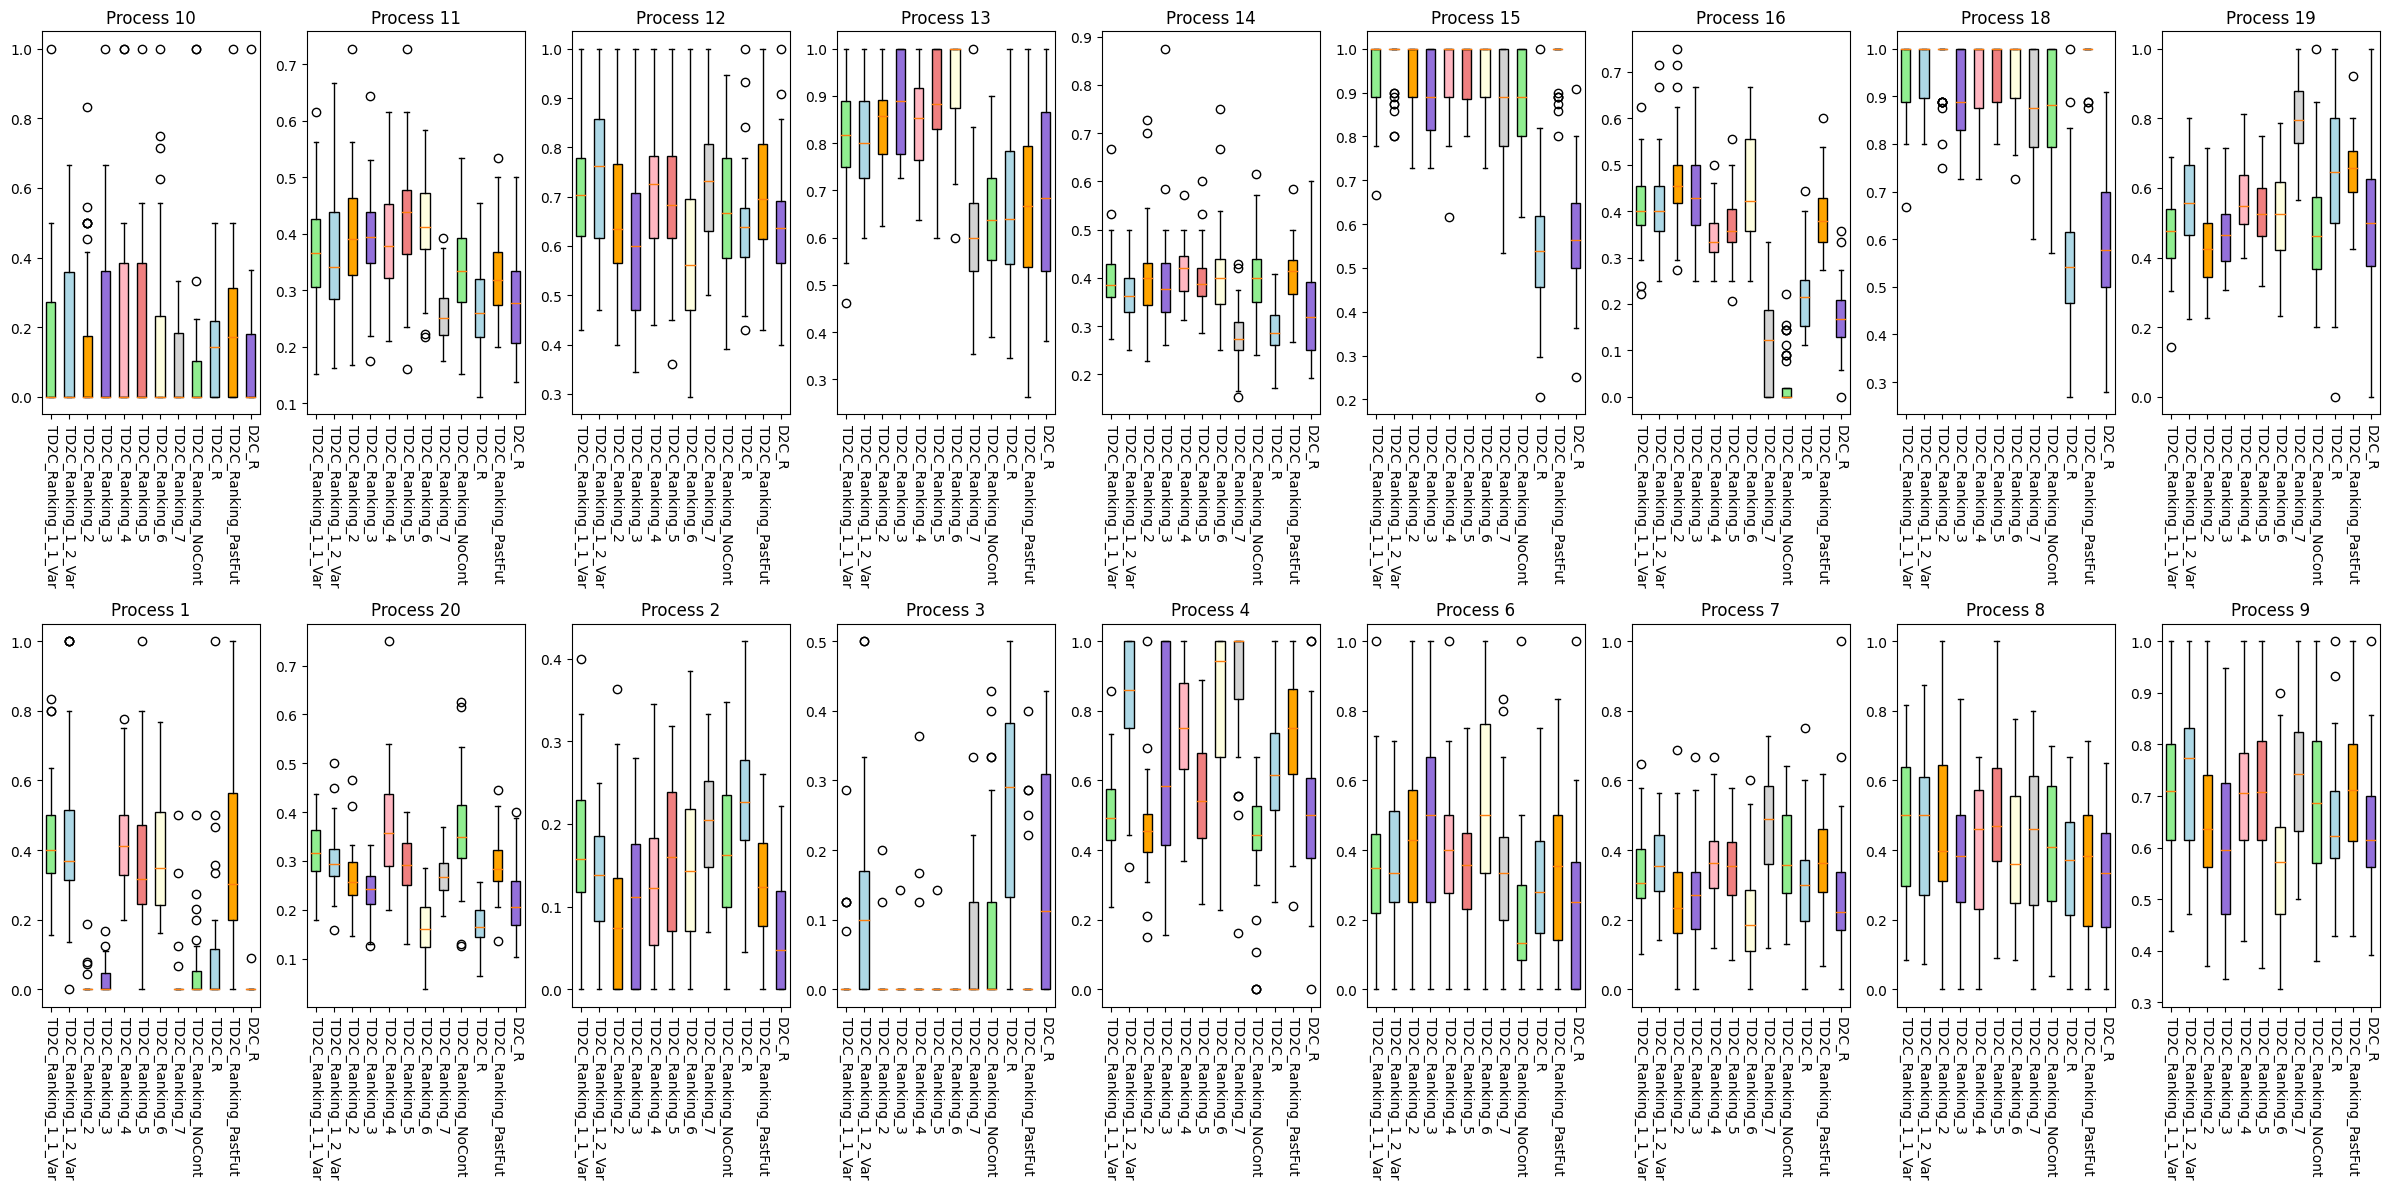

In [87]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



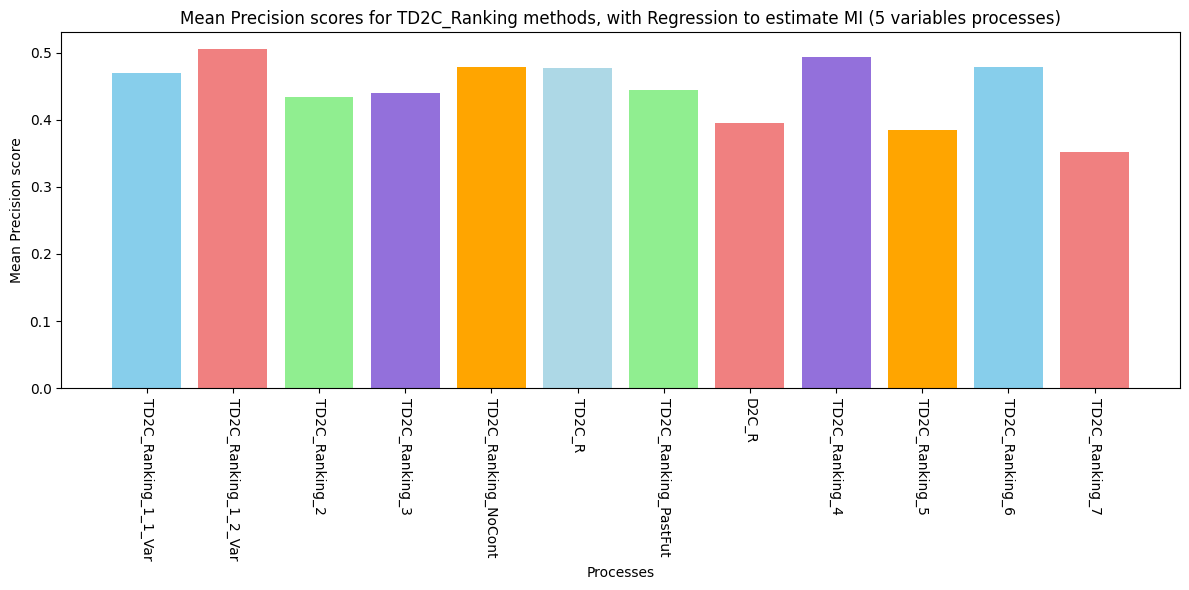

In [88]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean Precision score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [89]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='Precision')

df['Precision'] = df['Precision'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='Precision')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_precision_process': 'TD2C_+Ranking_1_1_Var_precision_process',
                        'TD2C_+Ranking_1_2_Var_precision_process': 'TD2C_+Ranking_1_2_Var_precision_process',
                        # 'TD2C_+Ranking_1_3_Var_precision_process': 'TD2C_+Ranking_1_3_Var_precision_process',
                        # 'TD2C_+Ranking_1_10_Var_precision_process': 'TD2C_+Ranking_1_10_Var_precision_process',
                        'TD2C_+Ranking_2_precision_process': 'TD2C_+Ranking_2_precision_process',
                        'TD2C_+Ranking_3_precision_process': 'TD2C_+Ranking_3_precision_process',
                        'TD2C_+Ranking_4_precision_process': 'TD2C_+Ranking_4_precision_process',
                        'TD2C_+Ranking_NoCont_precision_process': 'TD2C_+Ranking_NoCont_precision_process',
                        'TD2C_R_precision_process': 'TD2C_R_precision_process',
                        'TD2C_+Ranking_PastFut_precision_process': 'TD2C_+Ranking_PastFut_precision_process',
                        'D2C_R_precision_process': 'D2C_R_precision_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv', index=False)

df

method  Process ID     D2C_R    TD2C_R  TD2C_Ranking_1_1_Var  \
0                1  0.046017  0.395513              0.426413   
1                2  0.169735  0.148211              0.166668   
2                3  0.073322  0.000000              0.018601   
3                4  0.428446  0.819794              0.507370   
4                6  0.187840  0.535873              0.342704   
5                7  0.369211  0.195722              0.332615   
6                8  0.400206  0.394258              0.474958   
7                9  0.683801  0.570043              0.704806   
8               10  0.094594  0.157674              0.133768   
9               11  0.332648  0.416202              0.372961   
10              12  0.675911  0.591966              0.694970   
11              13  0.637955  0.920159              0.807453   
12              14  0.399668  0.405803              0.395554   
13              15  0.880632  0.951016              0.950595   
14              16  0.031635  0.457107              0.408964   
15              18  0.870252  0.956294              0.946528   
16              19  0.483441  0.511962              0.468227   
17              20  0.361594  0.163958              0.312152   

method  TD2C_Ranking_1_2_Var  TD2C_Ranking_2  TD2C_Ranking_3  TD2C_Ranking_4  \
0                   0.449041        0.009483        0.027421        0.425324   
1                   0.133452        0.094042        0.108714        0.121491   
2                   0.117423        0.008125        0.003571        0.016383   
3                   0.846805        0.457013        0.655253        0.755503   
4                   0.363707        0.406052        0.476657        0.389574   
5                   0.362430        0.253315        0.275898        0.368695   
6                   0.462735        0.450305        0.372596        0.403387   
7                   0.721459        0.640784        0.602625        0.703184   
8                   0.156289        0.128750        0.165443        0.199924   
9                   0.359549        0.384434        0.391993        0.388923   
10                  0.727261        0.647208        0.606324        0.701977   
11                  0.816172        0.843161        0.889789        0.844376   
12                  0.361049        0.407395        0.391476        0.418187   
13                  0.972401        0.955483        0.893875        0.943520   
14                  0.414515        0.472533        0.447758        0.347990   
15                  0.960951        0.968958        0.897253        0.929551   
16                  0.564192        0.427816        0.464357        0.560423   
17                  0.303104        0.263124        0.238100        0.370233   

method  TD2C_Ranking_5  TD2C_Ranking_6  TD2C_Ranking_7  TD2C_Ranking_NoCont  \
0             0.096337        0.418766        0.002273             0.355354   
1             0.229579        0.127065        0.071251             0.154013   
2             0.260464        0.036091        0.158473             0.003571   
3             0.614516        0.728206        0.510313             0.561973   
4             0.282259        0.322797        0.227773             0.338025   
5             0.298806        0.356239        0.268989             0.355505   
6             0.362256        0.354354        0.318371             0.496190   
7             0.643680        0.700709        0.631583             0.695722   
8             0.151939        0.180586        0.106183             0.171676   
9             0.268567        0.329498        0.280925             0.419958   
10            0.639037        0.704186        0.637183             0.688912   
11            0.660377        0.666226        0.694285             0.891347   
12            0.288563        0.406482        0.332593             0.393147   
13            0.548352        0.977470        0.577516             0.944415   
14            0.217416        0.390641        0.170037             0.371832  

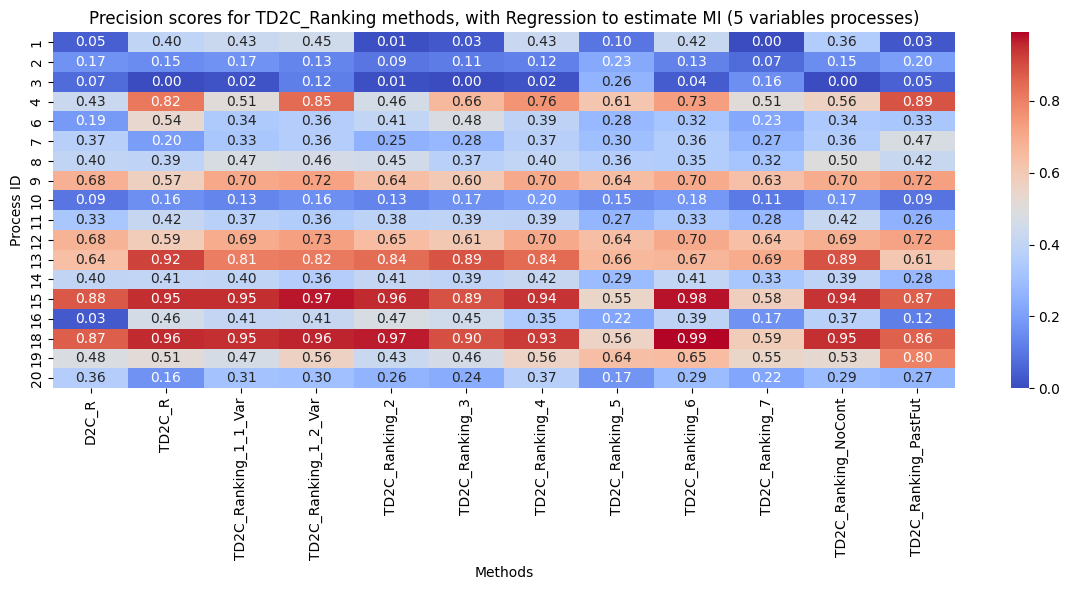

In [90]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_heatmap_TD2C_Ranking.pdf')

plt.show()

In [91]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'Precision'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_mean_proc.csv', index=False)

df

Process ID  Precision
0            1   0.223131
1            2   0.143613
2            3   0.062141
3            4   0.647822
4            6   0.350301
5            7   0.325869
6            8   0.409002
7            9   0.668566
8           10   0.144875
9           11   0.350274
10          12   0.669486
11          13   0.773570
12          14   0.373237
13          15   0.871978
14          16   0.320843
15          18   0.873493
16          19   0.553540
17          20   0.270643

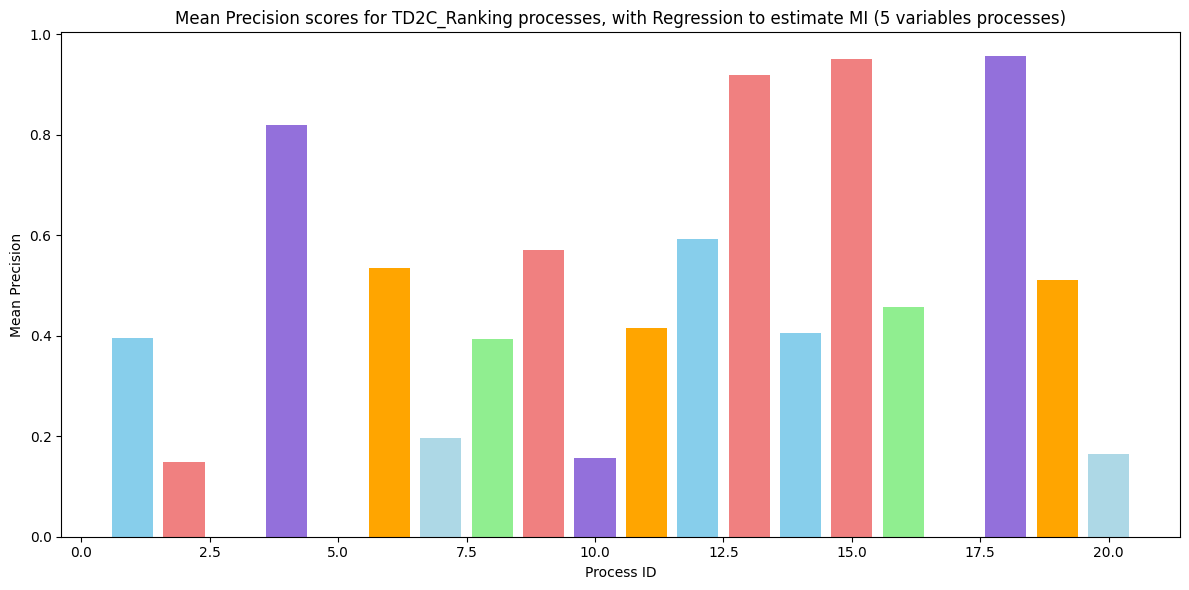

In [92]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean Precision scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean Precision')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [93]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'precision'})

df = df.sort_values(by='precision', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv', index=False)

df

method  precision
1   TD2C_Ranking_1_2_Var   0.505141
2         TD2C_Ranking_4   0.493814
3         TD2C_Ranking_6   0.479199
4    TD2C_Ranking_NoCont   0.478059
5                 TD2C_R   0.477309
6   TD2C_Ranking_1_1_Var   0.470295
7   TD2C_Ranking_PastFut   0.443828
8         TD2C_Ranking_3   0.439395
9         TD2C_Ranking_2   0.434332
10                 D2C_R   0.395939
11        TD2C_Ranking_5   0.385181
12        TD2C_Ranking_7   0.352431

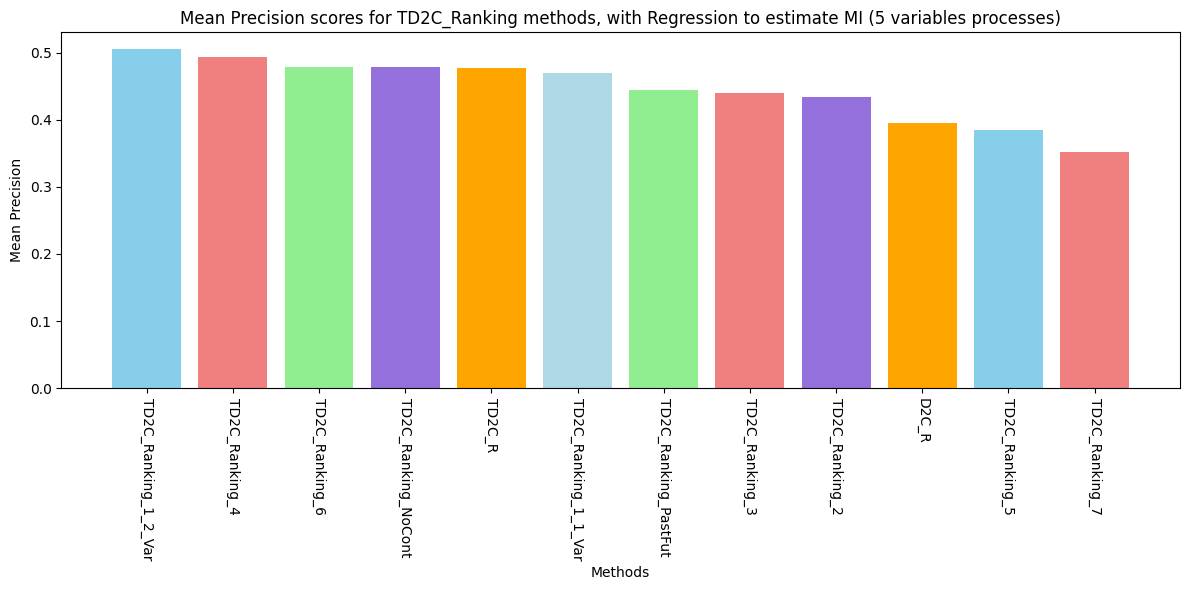

In [94]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['precision'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### Recall

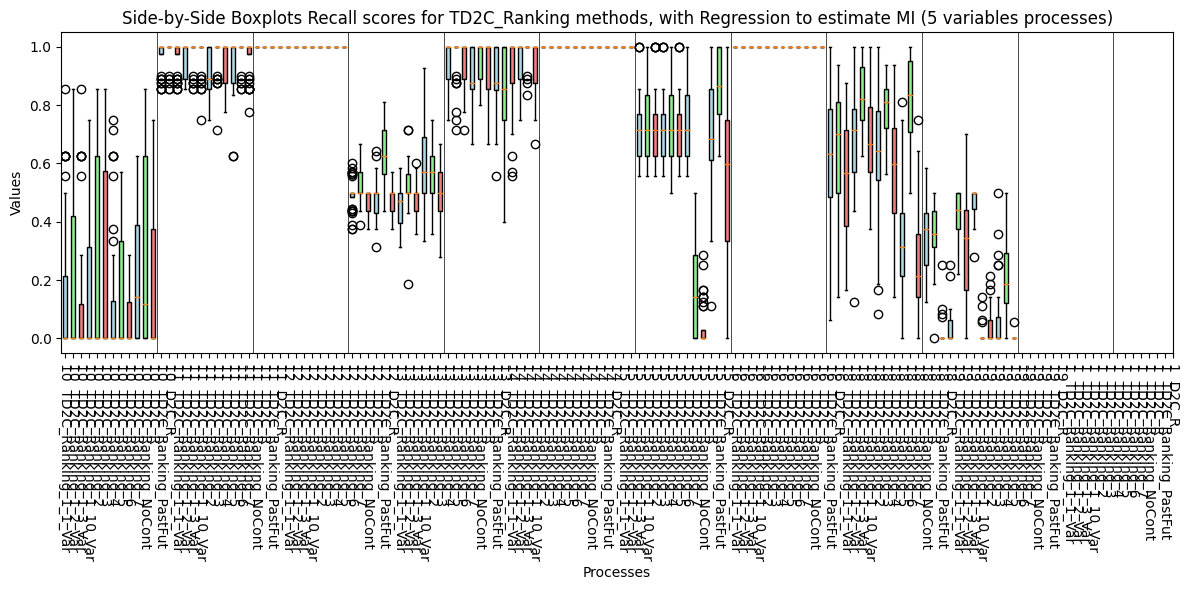

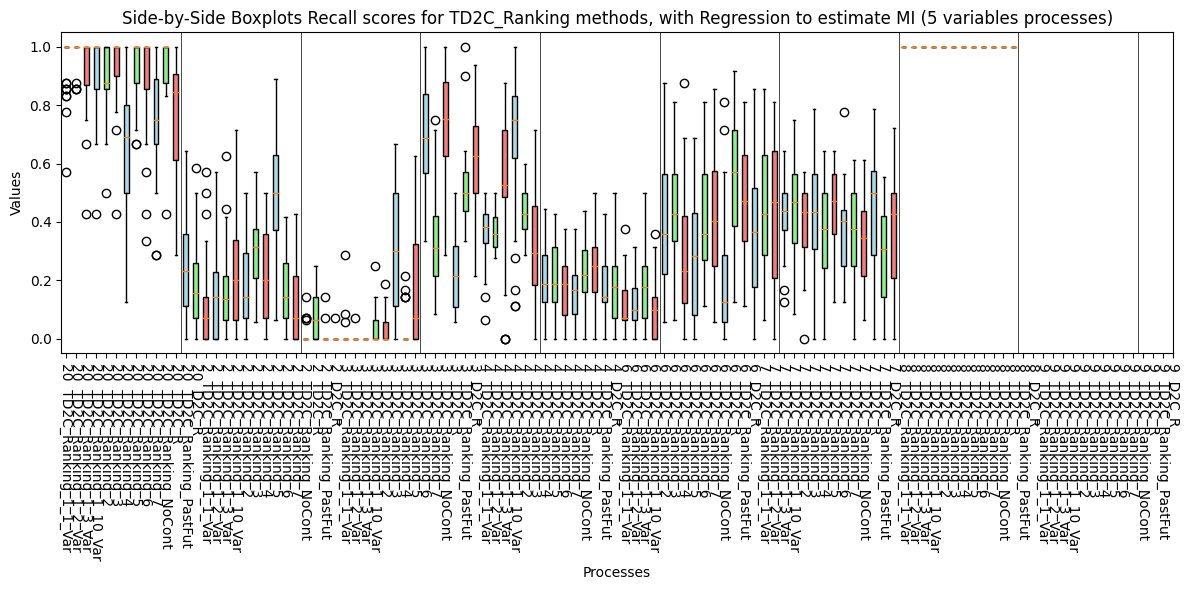

In [95]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)


# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

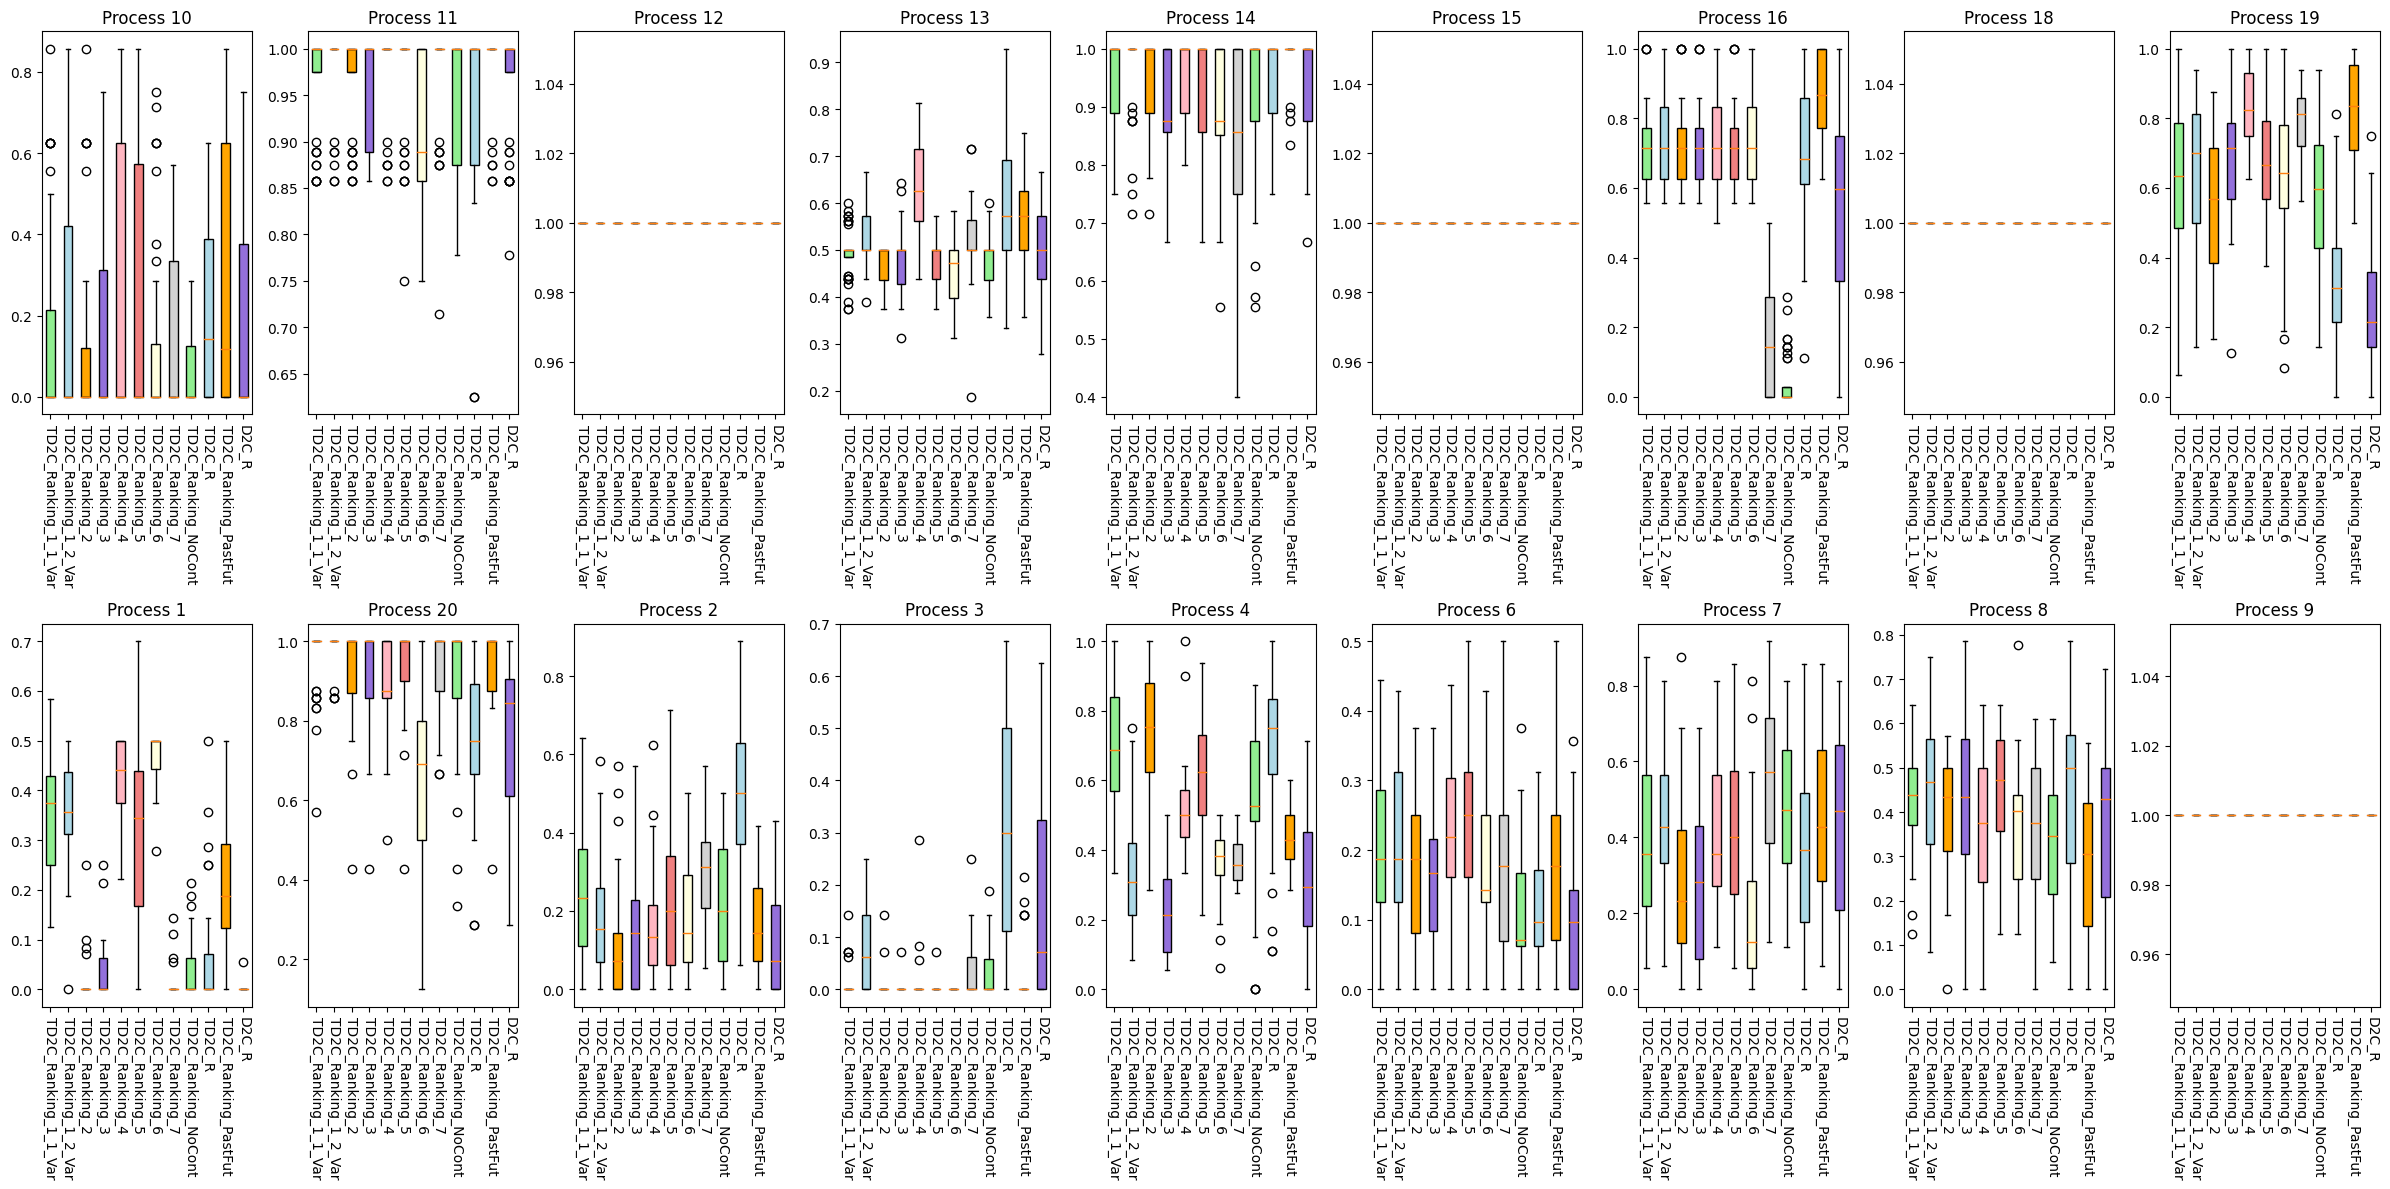

In [96]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



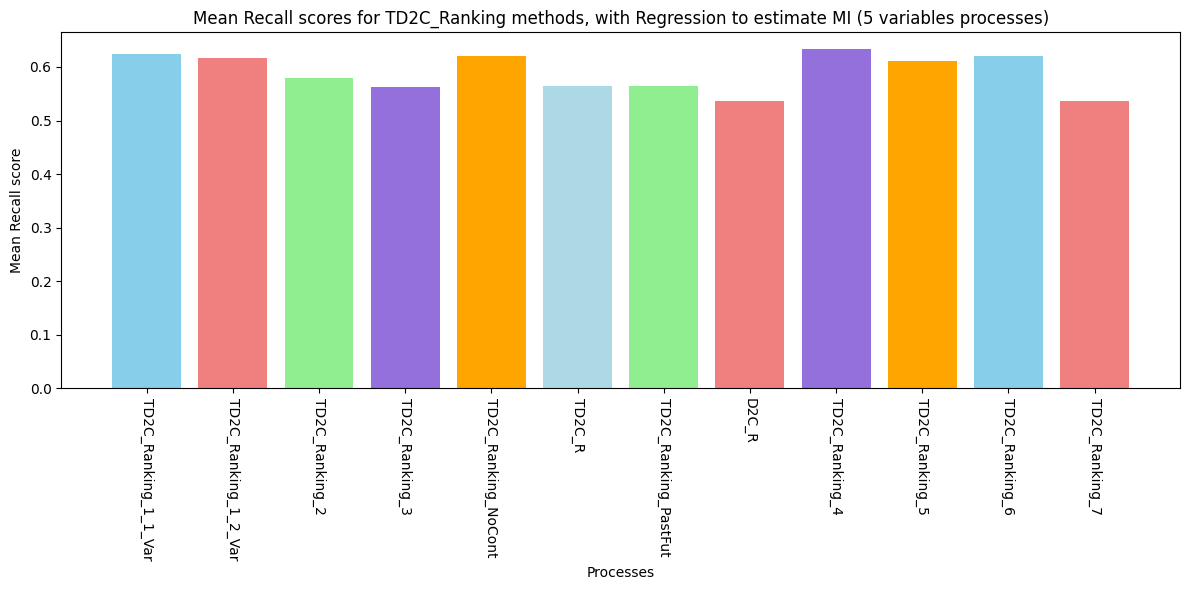

In [97]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean Recall score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [98]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)

                   

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='Recall')

df['Recall'] = df['Recall'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='Recall')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_recall_process': 'TD2C_+Ranking_1_1_Var_recall_process',
                        'TD2C_+Ranking_1_2_Var_recall_process': 'TD2C_+Ranking_1_2_Var_recall_process',
                        # 'TD2C_+Ranking_1_3_Var_recall_process': 'TD2C_+Ranking_1_3_Var_recall_process',
                        # 'TD2C_+Ranking_1_10_Var_recall_process': 'TD2C_+Ranking_1_10_Var_recall_process',
                        'TD2C_+Ranking_2_recall_process': 'TD2C_+Ranking_2_recall_process',
                        'TD2C_+Ranking_3_recall_process': 'TD2C_+Ranking_3_recall_process',
                        'TD2C_+Ranking_4_recall_process': 'TD2C_+Ranking_4_recall_process',
                        'TD2C_+Ranking_NoCont_recall_process': 'TD2C_+Ranking_NoCont_recall_process',
                        'TD2C_R_recall_process': 'TD2C_R_recall_process',
                        'TD2C_+Ranking_PastFut_recall_process': 'TD2C_+Ranking_PastFut_recall_process',
                        'D2C_R_recall_process': 'D2C_R_recall_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv', index=False)

df

method  Process ID     D2C_R    TD2C_R  TD2C_Ranking_1_1_Var  \
0                1  0.034420  0.476017              0.355918   
1                2  0.210094  0.188740              0.252902   
2                3  0.028770  0.000000              0.010491   
3                4  0.539191  0.365362              0.695724   
4                6  0.107341  0.167634              0.204216   
5                7  0.465947  0.194568              0.391691   
6                8  0.325694  0.366493              0.434449   
7                9  1.000000  1.000000              1.000000   
8               10  0.052371  0.131696              0.156895   
9               11  0.951895  0.920665              0.968631   
10              12  1.000000  1.000000              1.000000   
11              13  0.477316  0.451791              0.496176   
12              14  0.931488  0.887192              0.951647   
13              15  1.000000  1.000000              1.000000   
14              16  0.041121  0.728810              0.722113   
15              18  1.000000  1.000000              1.000000   
16              19  0.590823  0.616989              0.628348   
17              20  0.907827  0.652103              0.958433   

method  TD2C_Ranking_1_2_Var  TD2C_Ranking_2  TD2C_Ranking_3  TD2C_Ranking_4  \
0                   0.357812        0.012619        0.033006        0.432634   
1                   0.202480        0.121602        0.166245        0.159177   
2                   0.070238        0.005357        0.001786        0.010615   
3                   0.330471        0.749430        0.220258        0.524554   
4                   0.209921        0.167832        0.159375        0.230605   
5                   0.444494        0.270064        0.292956        0.407738   
6                   0.436384        0.389137        0.419519        0.361161   
7                   1.000000        1.000000        1.000000        1.000000   
8                   0.194762        0.126587        0.178244        0.242183   
9                   0.981677        0.969077        0.962480        0.978204   
10                  1.000000        1.000000        1.000000        1.000000   
11                  0.525610        0.466592        0.481076        0.634891   
12                  0.966399        0.956062        0.891706        0.960774   
13                  1.000000        1.000000        1.000000        1.000000   
14                  0.719464        0.719782        0.728016        0.732738   
15                  1.000000        1.000000        1.000000        1.000000   
16                  0.678795        0.545833        0.683532        0.829836   
17                  0.986161        0.929454        0.912054        0.890655   

method  TD2C_Ranking_5  TD2C_Ranking_6  TD2C_Ranking_7  TD2C_Ranking_NoCont  \
0             0.058924        0.209191        0.001389             0.316647   
1             0.488914        0.171925        0.131076             0.221602   
2             0.308730        0.020238        0.179315             0.001786   
3             0.689881        0.431319        0.316925             0.612277   
4             0.110441        0.171701        0.097123             0.236210   
5             0.378423        0.450223        0.416691             0.415055   
6             0.441915        0.282242        0.377356             0.450918   
7             1.000000        1.000000        1.000000             1.000000   
8             0.208819        0.248403        0.163681             0.204762   
9             0.935615        0.981329        0.965407             0.968730   
10            1.000000        1.000000        1.000000             1.000000   
11            0.603953        0.572827        0.509722             0.472793   
12            0.958343        0.987431        0.938700             0.917847   
13            1.000000        1.000000        1.000000             1.000000   
14            0.707937        0.864514        0.548046             0.722738  

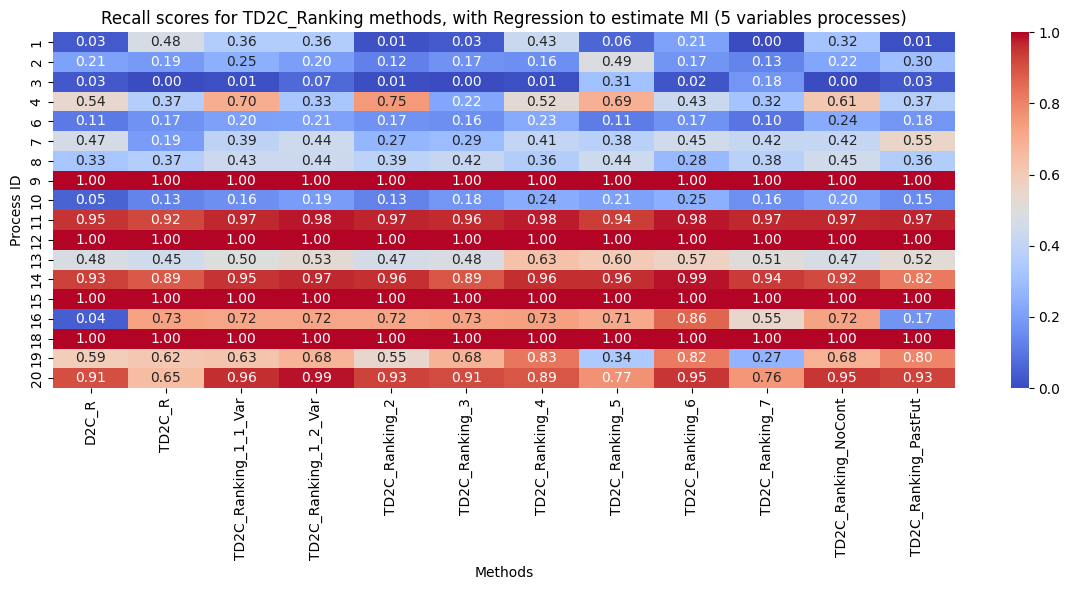

In [99]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_heatmap_TD2C_Ranking.pdf')

plt.show()

In [100]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'Recall'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_mean_proc.csv', index=False)

df

Process ID    Recall
0            1  0.191490
1            2  0.218248
2            3  0.055483
3            4  0.486957
4            6  0.169924
5            7  0.390174
6            8  0.387074
7            9  1.000000
8           10  0.171608
9           11  0.963030
10          12  1.000000
11          13  0.517819
12          14  0.930915
13          15  1.000000
14          16  0.617375
15          18  1.000000
16          19  0.623491
17          20  0.882104

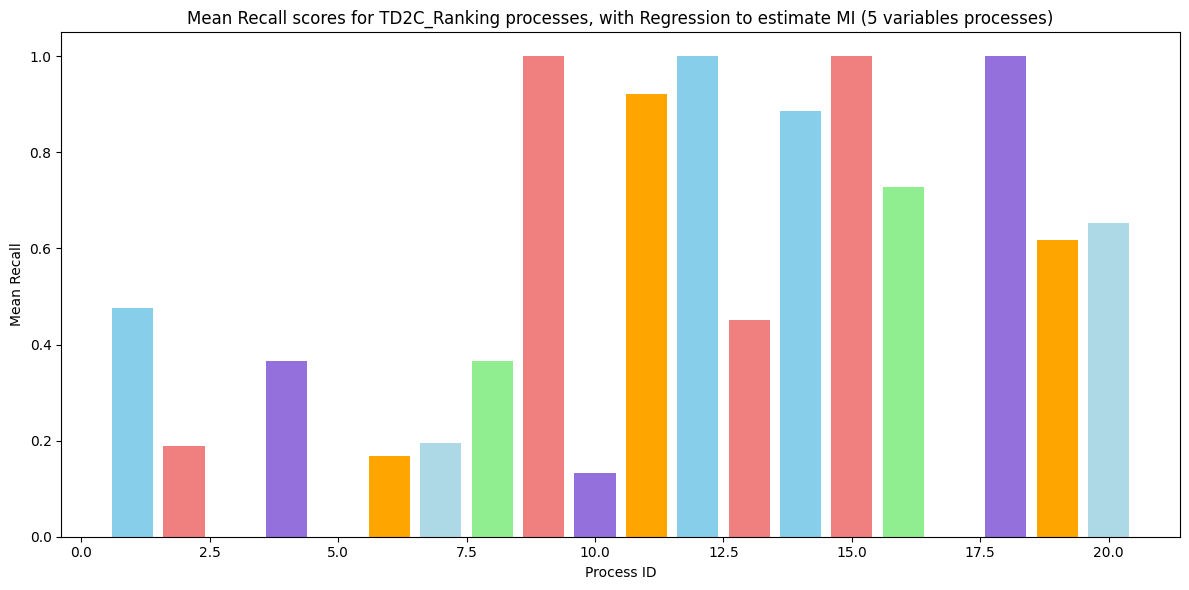

In [101]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean Recall scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean Recall')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [102]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'recall'})

df = df.sort_values(by='recall', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv', index=False)

df

method    recall
1         TD2C_Ranking_4  0.633098
2   TD2C_Ranking_1_1_Var  0.623757
3    TD2C_Ranking_NoCont  0.620675
4         TD2C_Ranking_6  0.619920
5   TD2C_Ranking_1_2_Var  0.616926
6         TD2C_Ranking_5  0.611225
7         TD2C_Ranking_2  0.579413
8   TD2C_Ranking_PastFut  0.564901
9                 TD2C_R  0.563781
10        TD2C_Ranking_3  0.562792
11        TD2C_Ranking_7  0.537068
12                 D2C_R  0.536906

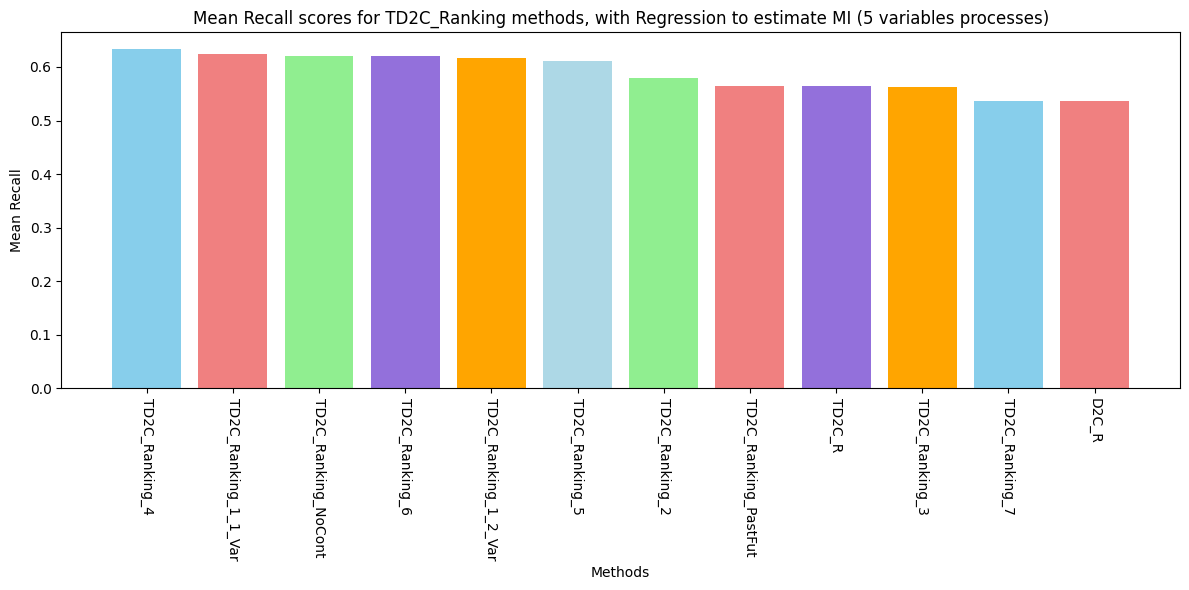

In [103]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['recall'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### F1

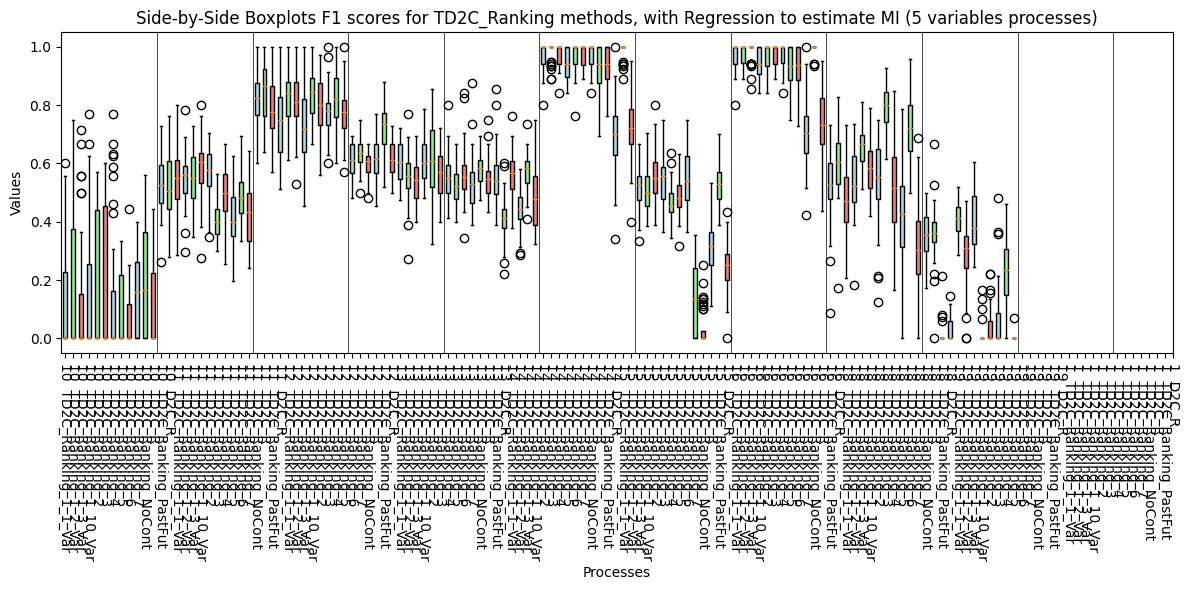

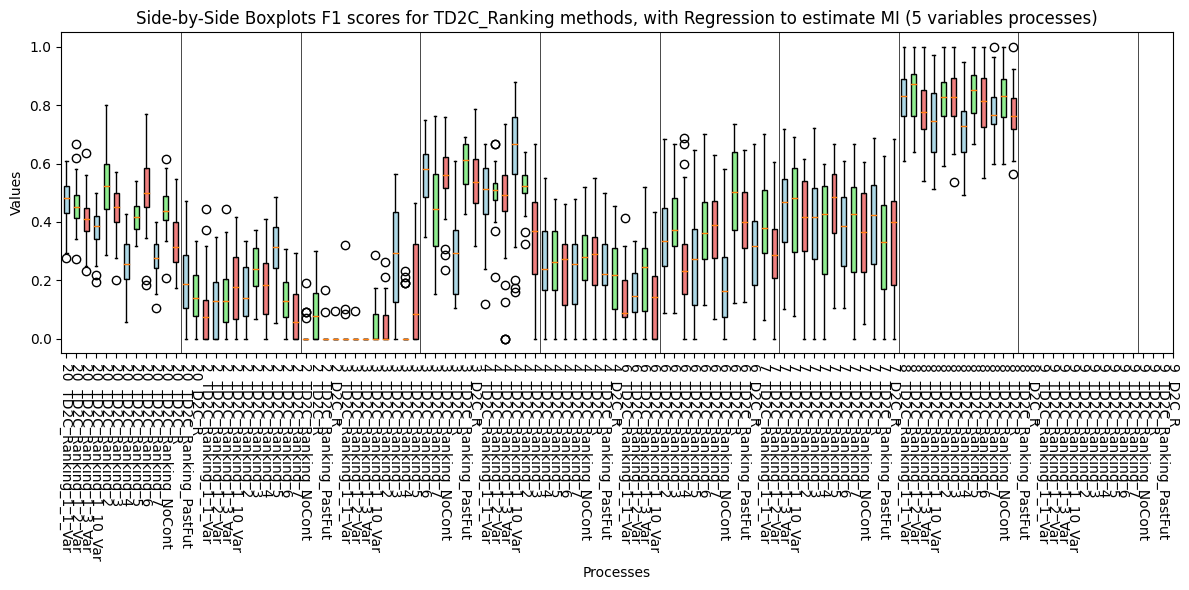

In [104]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

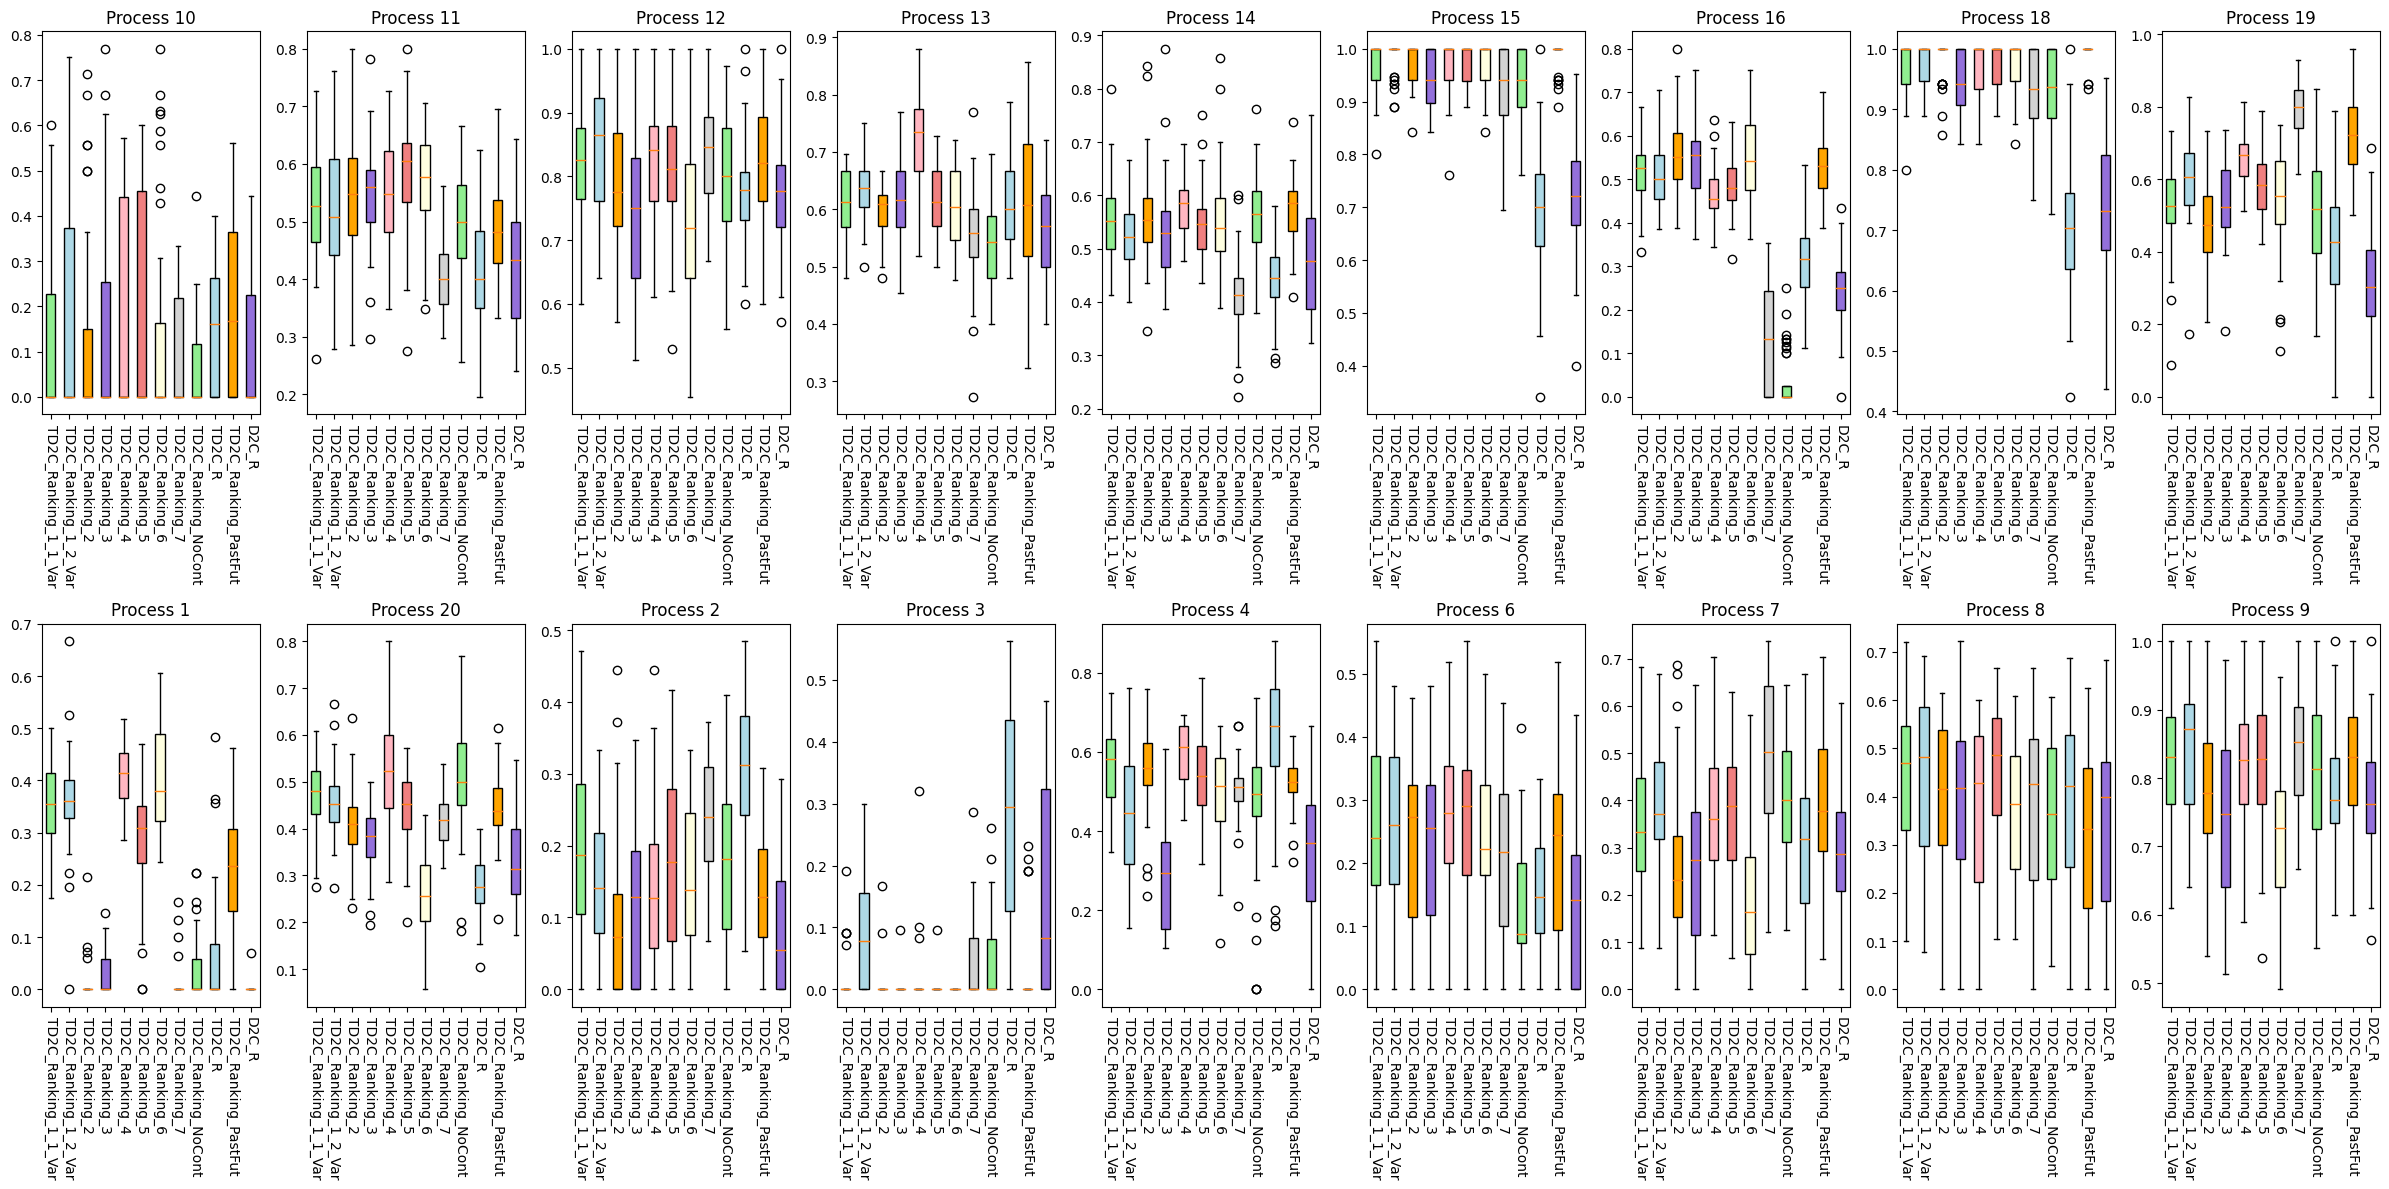

In [105]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)


# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



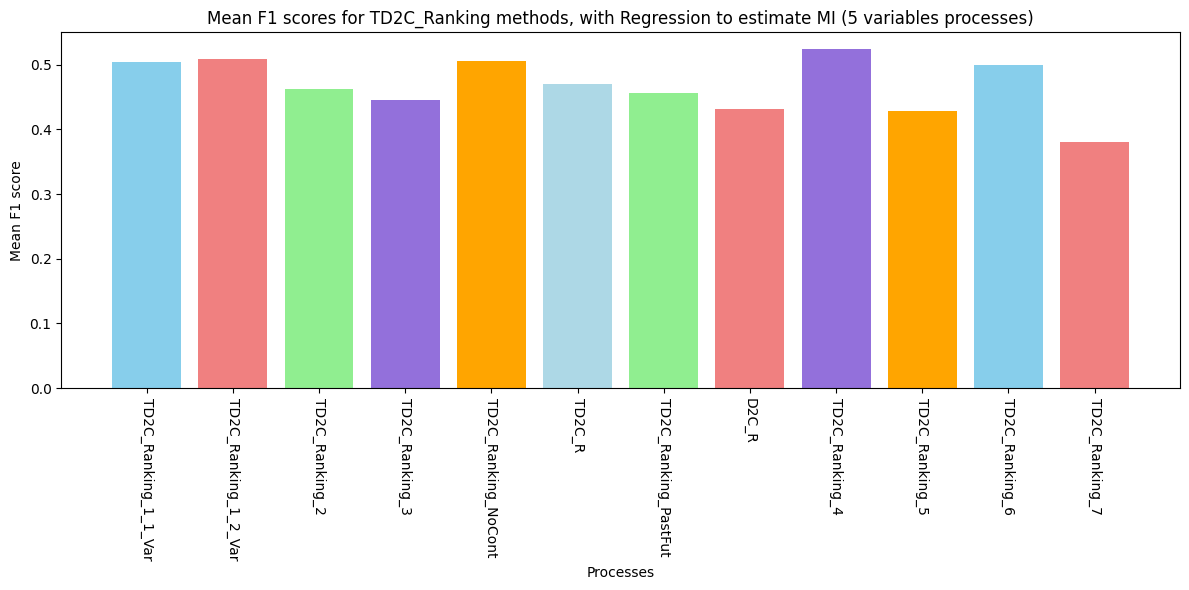

In [106]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean F1 score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [107]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='F1')

df['F1'] = df['F1'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='F1')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_f1_process': 'TD2C_+Ranking_1_1_Var_f1_process',
                        'TD2C_+Ranking_1_2_Var_f1_process': 'TD2C_+Ranking_1_2_Var_f1_process',
                        # 'TD2C_+Ranking_1_3_Var_f1_process': 'TD2C_+Ranking_1_3_Var_f1_process',
                        # 'TD2C_+Ranking_1_10_Var_f1_process': 'TD2C_+Ranking_1_10_Var_f1_process',
                        'TD2C_+Ranking_2_f1_process': 'TD2C_+Ranking_2_f1_process',
                        'TD2C_+Ranking_3_f1_process': 'TD2C_+Ranking_3_f1_process',
                        'TD2C_+Ranking_4_f1_process': 'TD2C_+Ranking_4_f1_process',
                        'TD2C_+Ranking_NoCont_f1_process': 'TD2C_+Ranking_NoCont_f1_process',
                        'TD2C_R_f1_process': 'TD2C_R_f1_process',
                        'TD2C_+Ranking_PastFut_f1_process': 'TD2C_+Ranking_PastFut_f1_process',
                        'D2C_R_f1_process': 'D2C_R_f1_process'})


# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv', index=False)

df

method  Process ID     D2C_R    TD2C_R  TD2C_Ranking_1_1_Var  \
0                1  0.035469  0.408616              0.357676   
1                2  0.179995  0.159623              0.195283   
2                3  0.040110  0.000000              0.013366   
3                4  0.469539  0.484684              0.567062   
4                6  0.130319  0.245739              0.248828   
5                7  0.397752  0.184604              0.347843   
6                8  0.354105  0.367773              0.440544   
7                9  0.801437  0.716684              0.818030   
8               10  0.058366  0.137479              0.129501   
9               11  0.487688  0.565950              0.531337   
10              12  0.797203  0.733131              0.811969   
11              13  0.539353  0.600931              0.610039   
12              14  0.554146  0.551322              0.555343   
13              15  0.931135  0.973338              0.972991   
14              16  0.035094  0.551306              0.514378   
15              18  0.924834  0.976124              0.970776   
16              19  0.512056  0.542294              0.519699   
17              20  0.509839  0.259767              0.468698   

method  TD2C_Ranking_1_2_Var  TD2C_Ranking_2  TD2C_Ranking_3  TD2C_Ranking_4  \
0                   0.361788        0.010658        0.026992        0.407916   
1                   0.154861        0.103935        0.126331        0.134926   
2                   0.086777        0.006439        0.002381        0.012583   
3                   0.437305        0.551552        0.286924        0.594518   
4                   0.260491        0.230763        0.230784        0.281699   
5                   0.389385        0.250878        0.269177        0.375090   
6                   0.439959        0.400616        0.382977        0.375983   
7                   0.828195        0.772011        0.740630        0.816612   
8                   0.163518        0.120893        0.165523        0.191644   
9                   0.517988        0.541278        0.550245        0.548905   
10                  0.832125        0.776739        0.744051        0.815468   
11                  0.635329        0.597377        0.620287        0.722047   
12                  0.523162        0.564731        0.536934        0.579938   
13                  0.985086        0.975914        0.941586        0.968808   
14                  0.515656        0.561207        0.543873        0.468121   
15                  0.979029        0.983161        0.943625        0.961627   
16                  0.597248        0.460620        0.539980        0.661294   
17                  0.460266        0.406691        0.375983        0.514659   

method  TD2C_Ranking_5  TD2C_Ranking_6  TD2C_Ranking_7  TD2C_Ranking_NoCont  \
0             0.062432        0.233904        0.001724             0.282367   
1             0.305785        0.143171        0.091233             0.177496   
2             0.278842        0.025318        0.164322             0.002381   
3             0.633325        0.522930        0.359855             0.557056   
4             0.150880        0.219817        0.129225             0.273111   
5             0.311635        0.390373        0.294017             0.371933   
6             0.393510        0.309511        0.339851             0.459670   
7             0.776447        0.814067        0.766711             0.810483   
8             0.157229        0.176009        0.110072             0.166129   
9             0.411874        0.488108        0.426617             0.577569   
10            0.773368        0.816326        0.770840             0.805249   
11            0.604200        0.611209        0.566053             0.614314   
12            0.440618        0.573467        0.482261             0.546754   
13            0.697162        0.987905        0.723394             0.969964   
14            0.317461        0.532960        0.242168             0.484049  

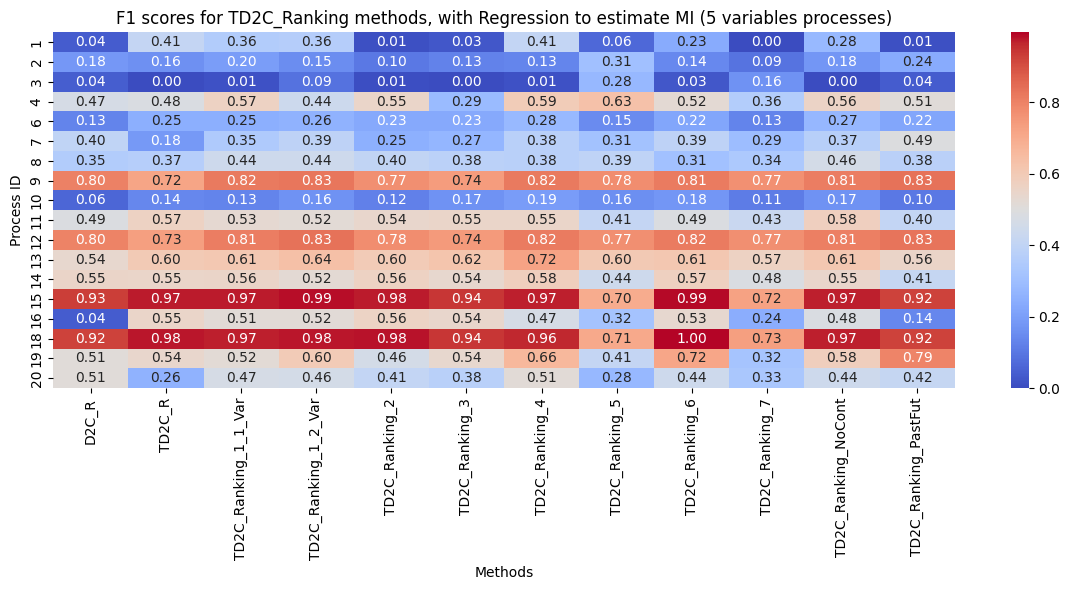

In [108]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_heatmap_TD2C_Ranking.pdf')

plt.show()

In [109]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'F1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_mean_proc.csv', index=False)

df

Process ID        F1
0            1  0.183430
1            2  0.167373
2            3  0.055689
3            4  0.497990
4            6  0.218287
5            7  0.339512
6            8  0.386962
7            9  0.791176
8           10  0.140031
9           11  0.504330
10          12  0.792142
11          13  0.606395
12          14  0.526857
13          15  0.920979
14          16  0.408593
15          18  0.922221
16          19  0.554782
17          20  0.408378

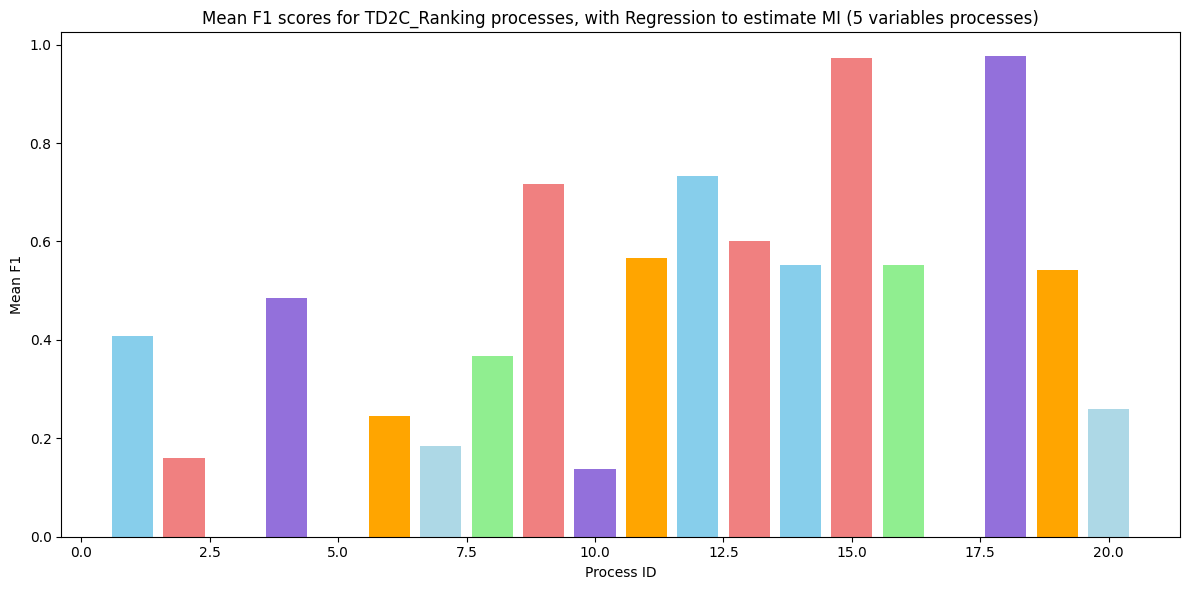

In [110]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean F1 scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean F1')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [111]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'f1'})

df = df.sort_values(by='f1', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv', index=False)

df

method        f1
1         TD2C_Ranking_4  0.523991
2   TD2C_Ranking_1_2_Var  0.509343
3    TD2C_Ranking_NoCont  0.505187
4   TD2C_Ranking_1_1_Var  0.504076
5         TD2C_Ranking_6  0.499740
6                 TD2C_R  0.469965
7         TD2C_Ranking_2  0.461970
8   TD2C_Ranking_PastFut  0.456421
9         TD2C_Ranking_3  0.446016
10                 D2C_R  0.431024
11        TD2C_Ranking_5  0.428270
12        TD2C_Ranking_7  0.380747

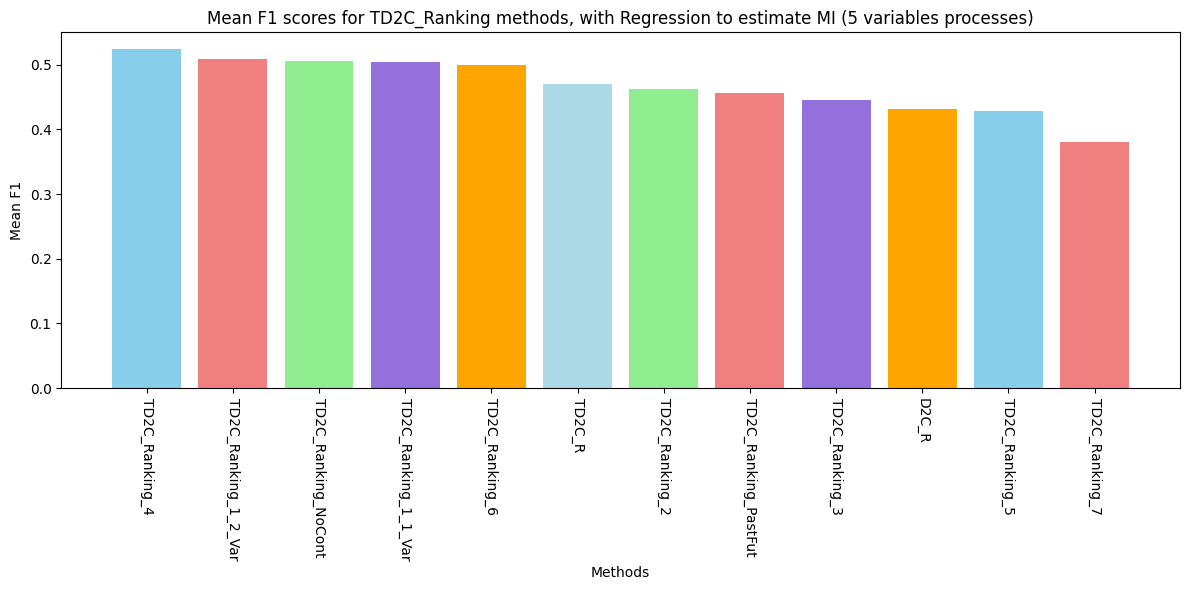

In [112]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['f1'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### PLOT SUMMARY - BEST METHOD OVERALL

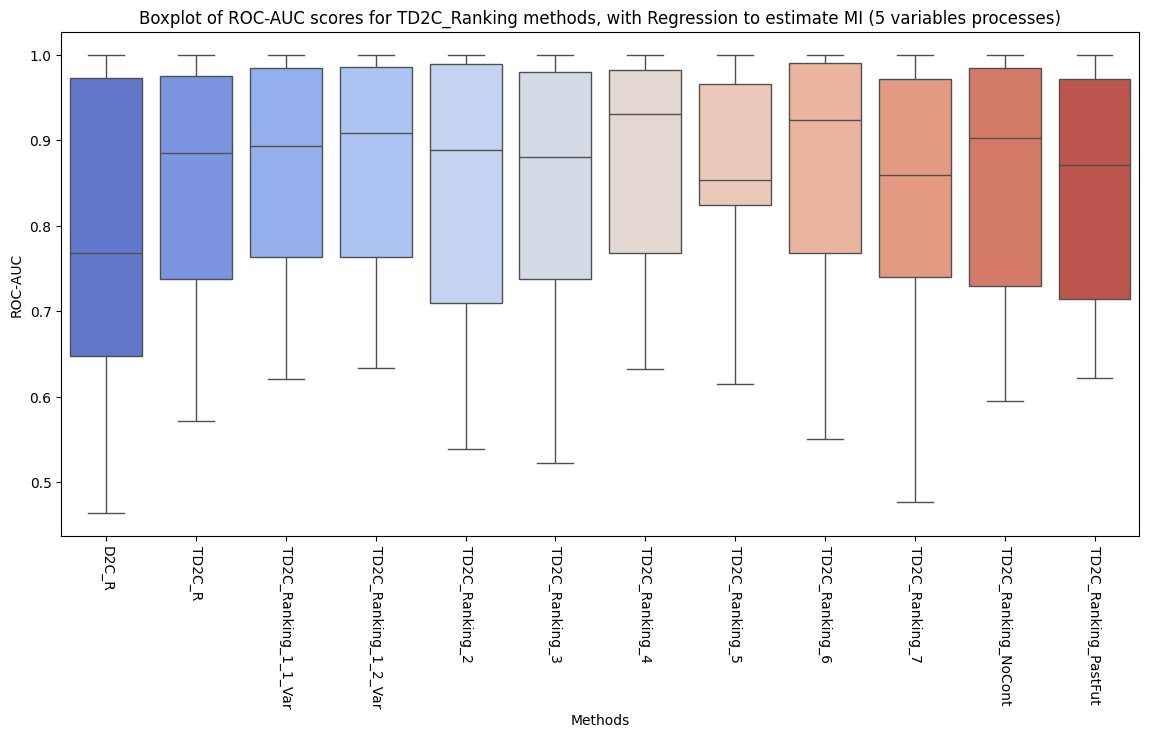

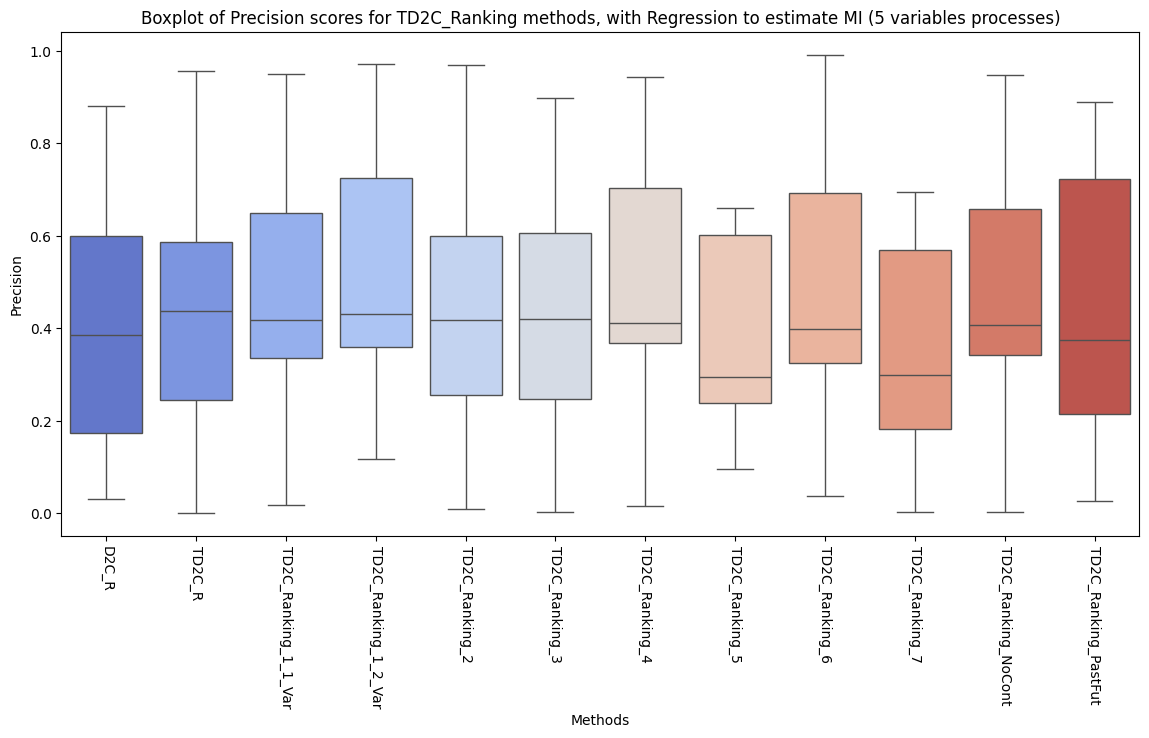

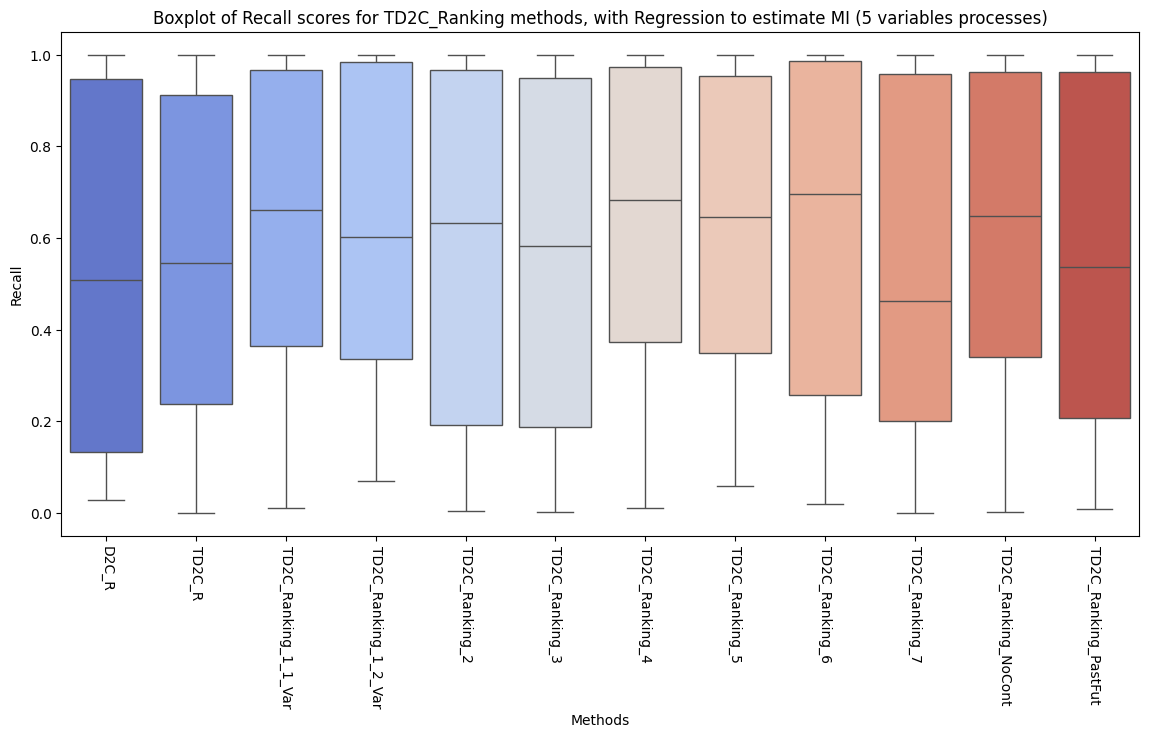

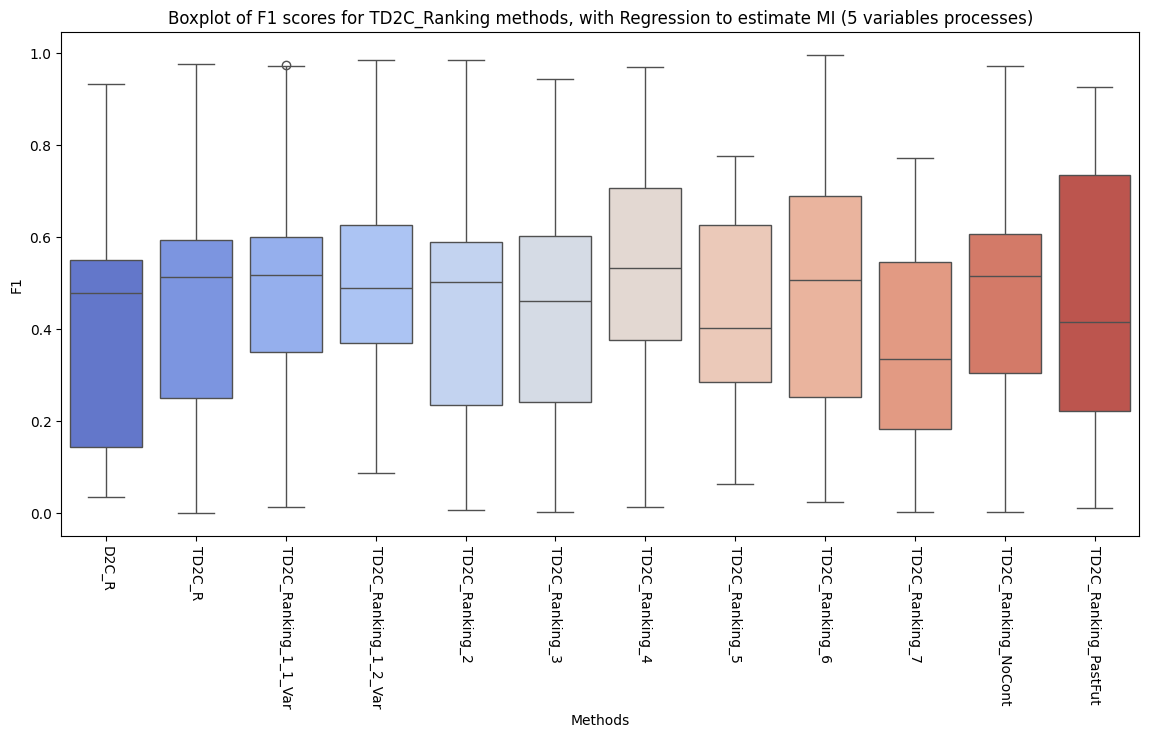

In [113]:
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')
# boxplot for ROC-AUC
df_r = df_r.set_index('Process ID')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_r, palette='coolwarm')
plt.title('Boxplot of ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.xticks(rotation=-90)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/roc_auc_boxplot_TD2C_all_methods.pdf')
plt.show()

df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')
# boxplot for Precision
df_p = df_p.set_index('Process ID')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_p, palette='coolwarm')
plt.title('Boxplot of Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Precision')
plt.tight_layout()
plt.xticks(rotation=-90)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_all_methods.pdf')
plt.show()

df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')
# boxplot for Recall
df_r = df_r.set_index('Process ID')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_r, palette='coolwarm')
plt.title('Boxplot of Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Recall')
plt.tight_layout()
plt.xticks(rotation=-90)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_all_methods.pdf')
plt.show()

df_f1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')
# boxplot for F1
df_f1 = df_f1.set_index('Process ID')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_f1, palette='coolwarm')
plt.title('Boxplot of F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('F1')
plt.tight_layout()
plt.xticks(rotation=-90)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_all_methods.pdf')
plt.show()


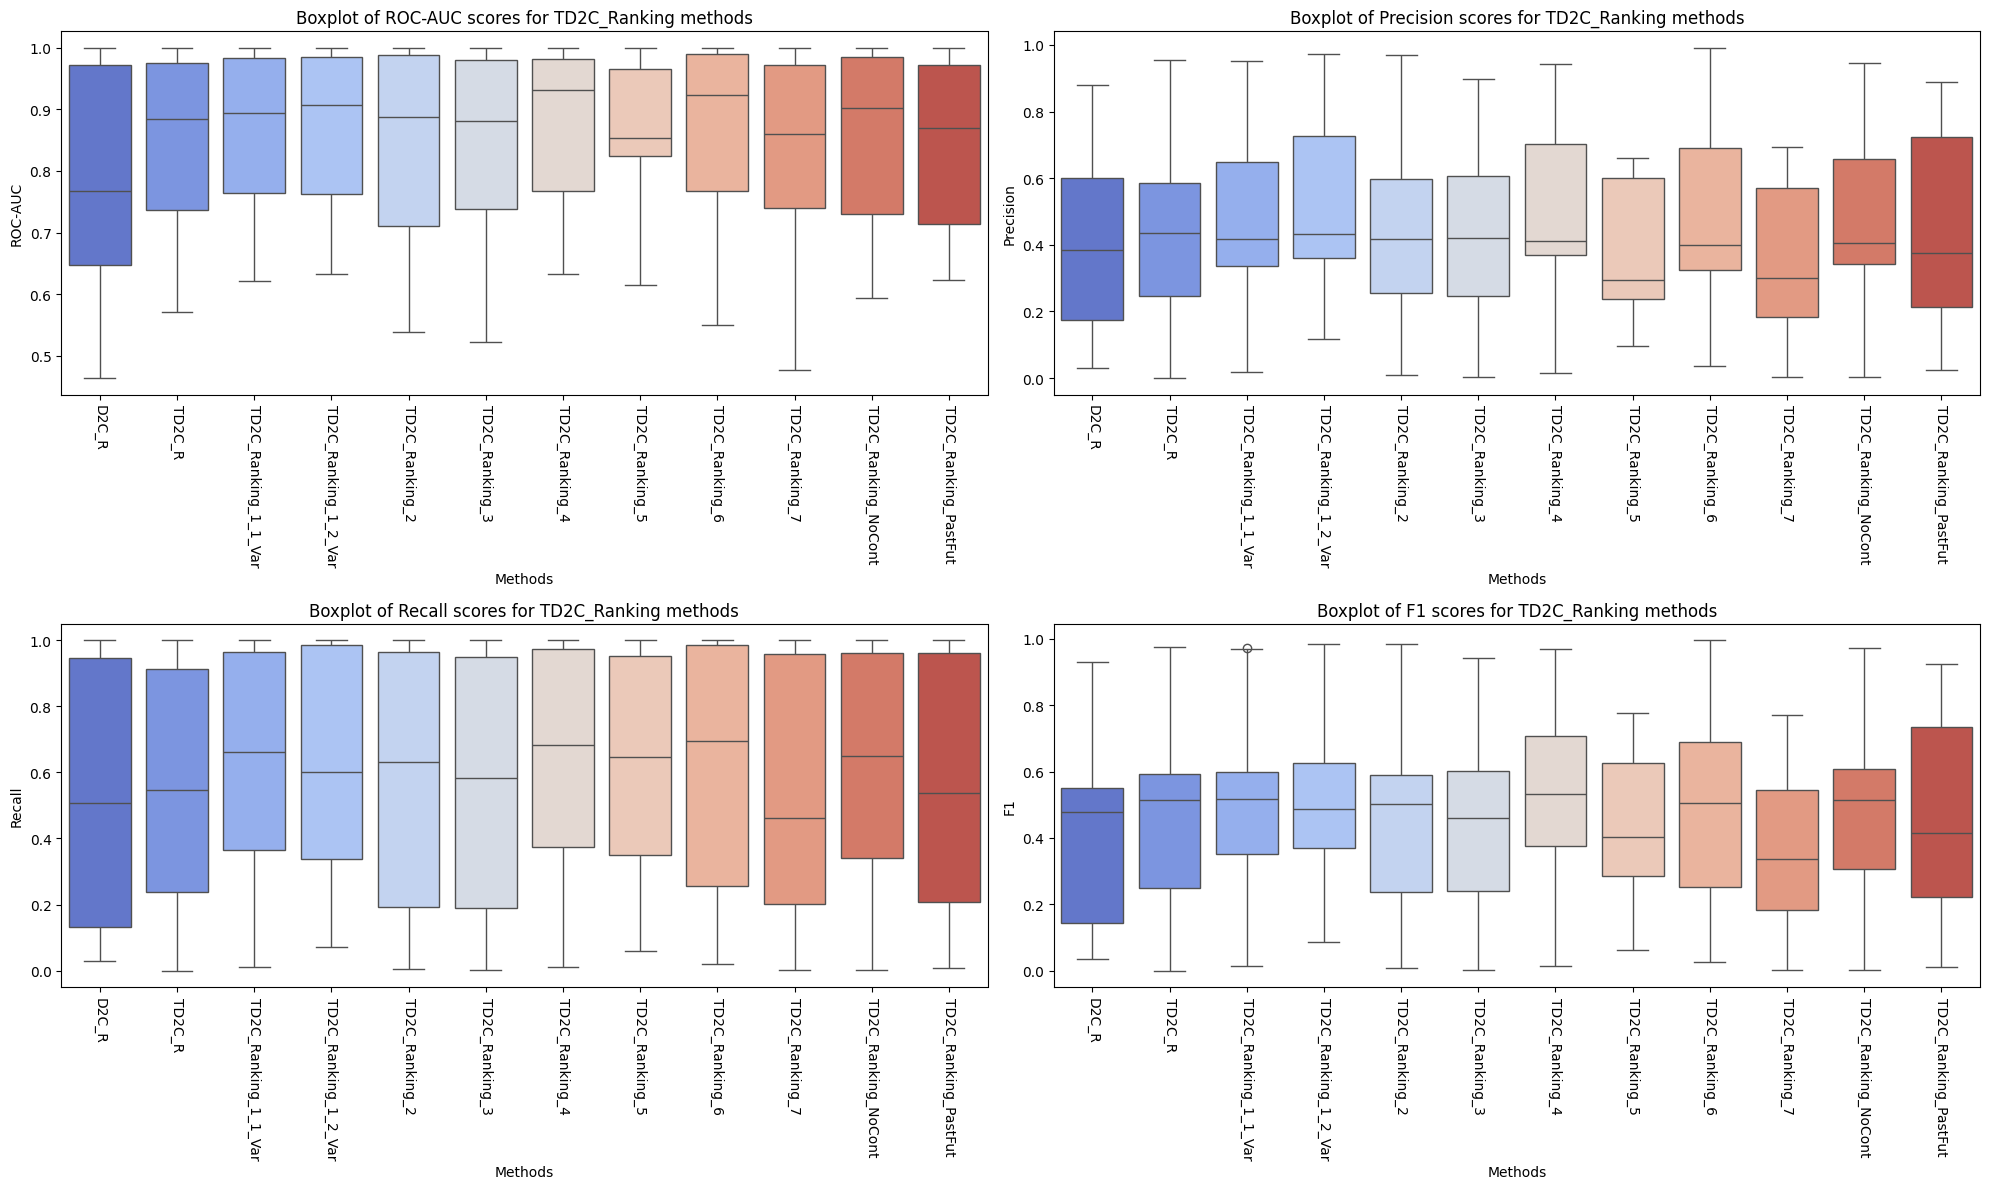

In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV files
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')
df_recall = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')
df_f1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# Set index
df_r = df_r.set_index('Process ID')
df_p = df_p.set_index('Process ID')
df_recall = df_recall.set_index('Process ID')
df_f1 = df_f1.set_index('Process ID')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot ROC-AUC
sns.boxplot(data=df_r, palette='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of ROC-AUC scores for TD2C_Ranking methods')
axes[0, 0].set_xlabel('Methods')
axes[0, 0].set_ylabel('ROC-AUC')
axes[0, 0].tick_params(axis='x', rotation=-90)

# Plot Precision
sns.boxplot(data=df_p, palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Precision scores for TD2C_Ranking methods')
axes[0, 1].set_xlabel('Methods')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=-90)

# Plot Recall
sns.boxplot(data=df_recall, palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Recall scores for TD2C_Ranking methods')
axes[1, 0].set_xlabel('Methods')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].tick_params(axis='x', rotation=-90)

# Plot F1
sns.boxplot(data=df_f1, palette='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of F1 scores for TD2C_Ranking methods')
axes[1, 1].set_xlabel('Methods')
axes[1, 1].set_ylabel('F1')
axes[1, 1].tick_params(axis='x', rotation=-90)

# Adjust layout
plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/combined_boxplot_TD2C_all_methods.pdf')
plt.show()

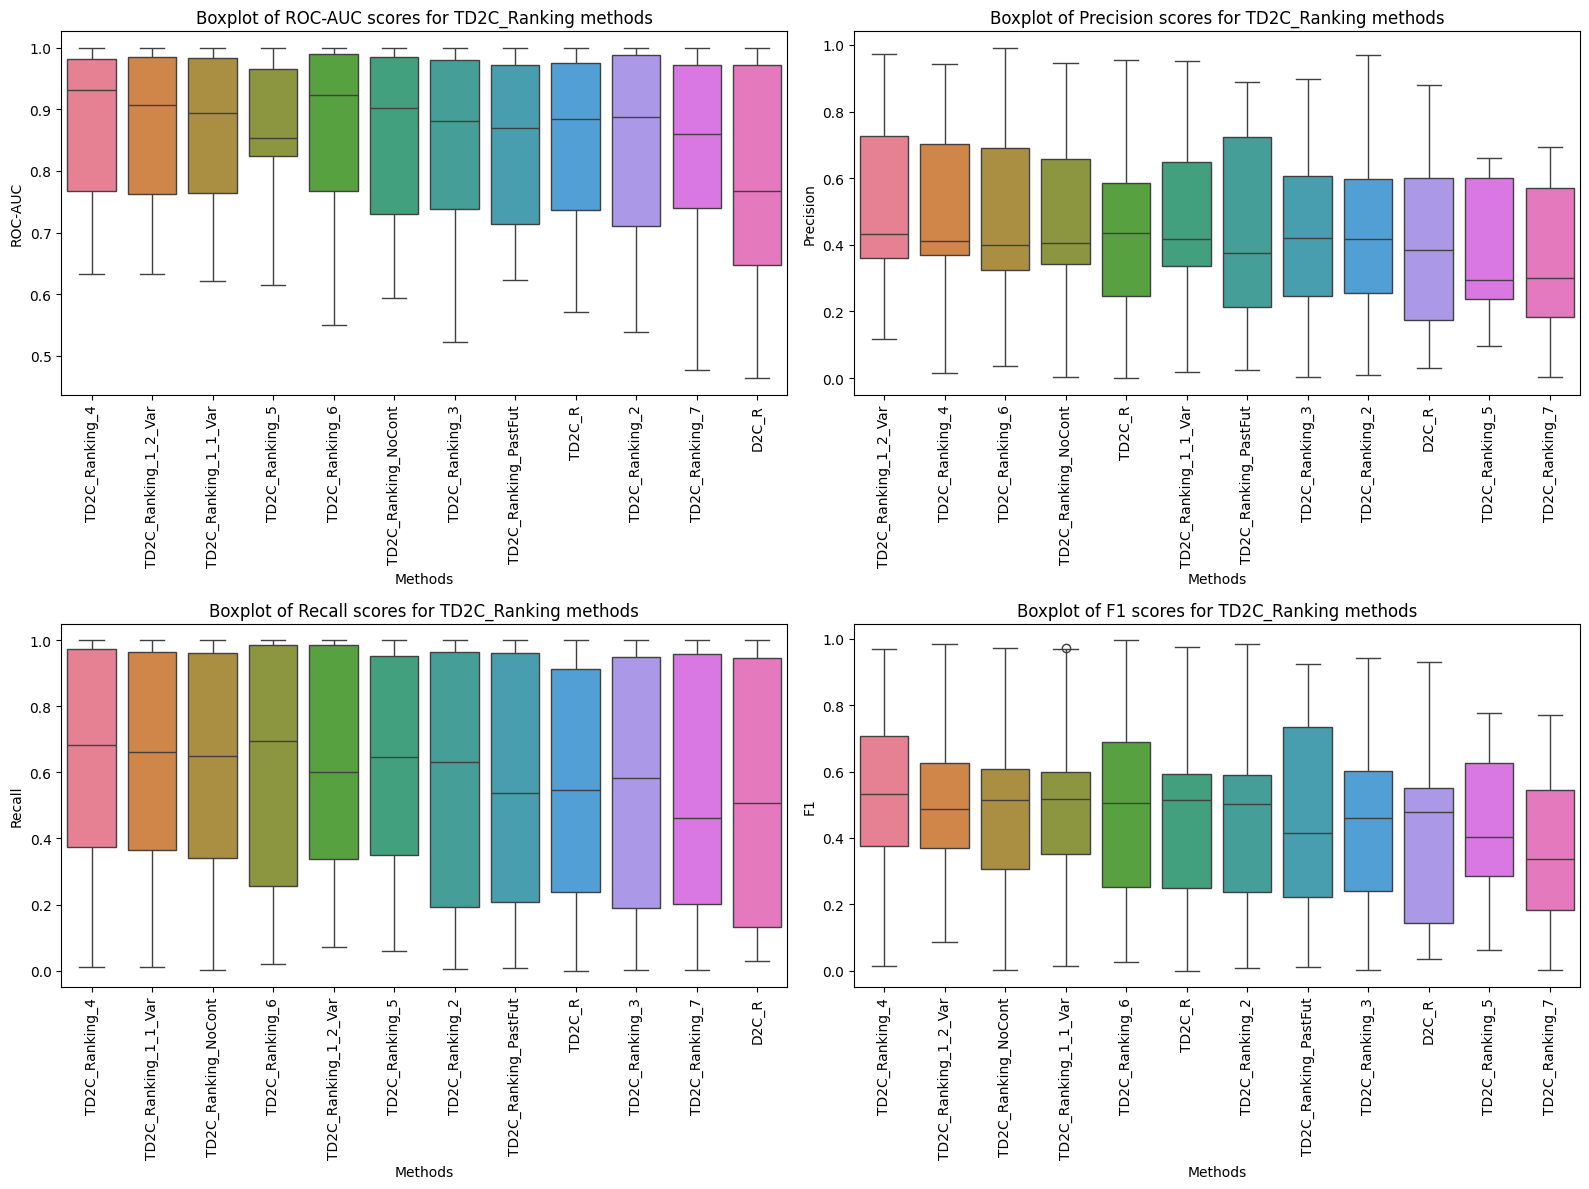

<Figure size 640x480 with 0 Axes>

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the DataFrames
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')
df_r_av = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv')
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')
df_p_av = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_rec = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')
df_rec_av = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_f1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')
df_f1_av = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# Remove the first column
df_r = df_r.drop('Process ID', axis=1)
df_p = df_p.drop('Process ID', axis=1)
df_rec = df_rec.drop('Process ID', axis=1)
df_f1 = df_f1.drop('Process ID', axis=1)

# Sort the columns to match the order of the average DataFrames' rows
df_r = df_r[df_r_av['method']]
df_p = df_p[df_p_av['method']]
df_rec = df_rec[df_rec_av['method']]
df_f1 = df_f1[df_f1_av['method']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot for ROC-AUC
sns.boxplot(data=df_r, orient='v', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of ROC-AUC scores for TD2C_Ranking methods')
axes[0, 0].set_xlabel('Methods')
axes[0, 0].set_ylabel('ROC-AUC')
axes[0, 0].tick_params(axis='x', rotation=90)

# Boxplot for Precision
sns.boxplot(data=df_p, orient='v', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Precision scores for TD2C_Ranking methods')
axes[0, 1].set_xlabel('Methods')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=90)

# Boxplot for Recall
sns.boxplot(data=df_rec, orient='v', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Recall scores for TD2C_Ranking methods')
axes[1, 0].set_xlabel('Methods')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].tick_params(axis='x', rotation=90)

# Boxplot for F1
sns.boxplot(data=df_f1, orient='v', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of F1 scores for TD2C_Ranking methods')
axes[1, 1].set_xlabel('Methods')
axes[1, 1].set_ylabel('F1')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/boxplot_TD2C_all_metrics.pdf')

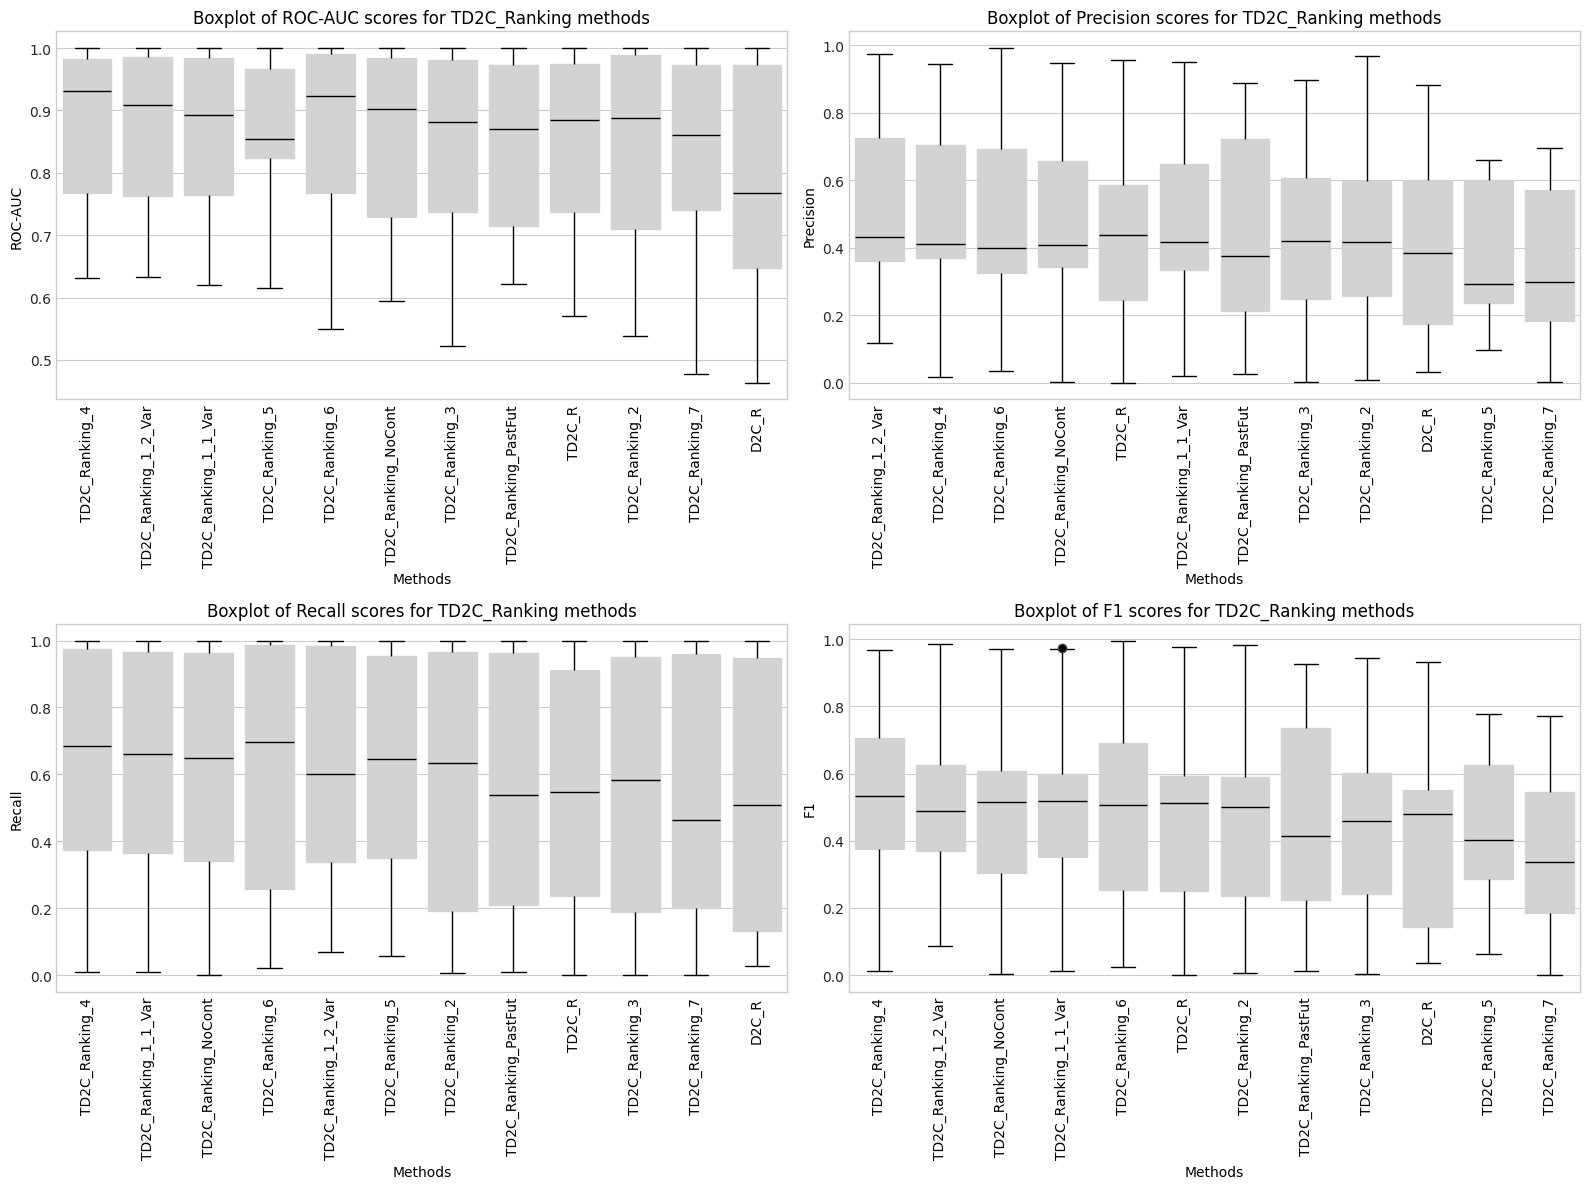

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style to whitegrid and force all colors to black
plt.style.use('seaborn-whitegrid')  # Clean grid style for black and white

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot for ROC-AUC
sns.boxplot(data=df_r, orient='v', ax=axes[0, 0], color='white', boxprops=dict(color="lightgrey"),
            medianprops=dict(color="black"), whiskerprops=dict(color="black"), capprops=dict(color="black"),
            flierprops=dict(markerfacecolor='black', marker='o', color='black'))
axes[0, 0].set_title('Boxplot of ROC-AUC scores for TD2C_Ranking methods', color='black')
axes[0, 0].set_xlabel('Methods', color='black')
axes[0, 0].set_ylabel('ROC-AUC', color='black')
axes[0, 0].tick_params(axis='x', rotation=90, colors='black')

# Boxplot for Precision
sns.boxplot(data=df_p, orient='v', ax=axes[0, 1], color='white', boxprops=dict(color="lightgrey"),
            medianprops=dict(color="black"), whiskerprops=dict(color="black"), capprops=dict(color="black"),
            flierprops=dict(markerfacecolor='black', marker='o', color='black'))
axes[0, 1].set_title('Boxplot of Precision scores for TD2C_Ranking methods', color='black')
axes[0, 1].set_xlabel('Methods', color='black')
axes[0, 1].set_ylabel('Precision', color='black')
axes[0, 1].tick_params(axis='x', rotation=90, colors='black')

# Boxplot for Recall
sns.boxplot(data=df_rec, orient='v', ax=axes[1, 0], color='white', boxprops=dict(color="lightgrey"),
            medianprops=dict(color="black"), whiskerprops=dict(color="black"), capprops=dict(color="black"),
            flierprops=dict(markerfacecolor='black', marker='o', color='black'))
axes[1, 0].set_title('Boxplot of Recall scores for TD2C_Ranking methods', color='black')
axes[1, 0].set_xlabel('Methods', color='black')
axes[1, 0].set_ylabel('Recall', color='black')
axes[1, 0].tick_params(axis='x', rotation=90, colors='black')

# Boxplot for F1
sns.boxplot(data=df_f1, orient='v', ax=axes[1, 1], color='white', boxprops=dict(color="lightgrey"),
            medianprops=dict(color="black"), whiskerprops=dict(color="black"), capprops=dict(color="black"),
            flierprops=dict(markerfacecolor='black', marker='o', color='black'))
axes[1, 1].set_title('Boxplot of F1 scores for TD2C_Ranking methods', color='black')
axes[1, 1].set_xlabel('Methods', color='black')
axes[1, 1].set_ylabel('F1', color='black')
axes[1, 1].tick_params(axis='x', rotation=90, colors='black')

plt.tight_layout()

# Save the plot as a PDF in black and white
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/boxplot_TD2C_all_metrics_bw.pdf', format='pdf')

plt.show()


In [139]:
# top 5 methods for roc-auc
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv')
df_r = df.head(8)

# for precision
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_p = df.head(8)

# for recall
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_re = df.head(8)

# for f1
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')
df_f = df.head(8)

# merge the dataframes
df = pd.merge(df_r, df_p, on='method')
df = pd.merge(df, df_re, on='method')
df = pd.merge(df, df_f, on='method')

df = df.rename(columns={'roc_auc': 'ROC-AUC', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/top_td2c_methods_merged.csv', index=False)

df # these methods are in the top 5 for all metrics


method   ROC-AUC  Precision    Recall        F1
0        TD2C_Ranking_4  0.871073   0.493814  0.633098  0.523991
1  TD2C_Ranking_1_2_Var  0.868241   0.505141  0.616926  0.509343
2  TD2C_Ranking_1_1_Var  0.864779   0.470295  0.623757  0.504076
3        TD2C_Ranking_6  0.861450   0.479199  0.619920  0.499740
4   TD2C_Ranking_NoCont  0.857416   0.478059  0.620675  0.505187
5  TD2C_Ranking_PastFut  0.841383   0.443828  0.564901  0.456421

In [134]:
# top 5 methods for roc-auc
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv')
df_r = df.head(8)

# for precision
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_p = df.head(8)

# for recall
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_re = df.head(8)

# for f1
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')
df_f = df.head(8)

# combine the dataframes without merging
df = pd.concat([df_r, df_p, df_re, df_f])

df = df.reset_index(drop=True)

df = df.rename(columns={'roc_auc': 'ROC-AUC', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/top_td2c_methods.csv', index=False)

df # these methods are in the top 5 for at least one metric

method   ROC-AUC  Precision    Recall        F1
0         TD2C_Ranking_4  0.871073        NaN       NaN       NaN
1   TD2C_Ranking_1_2_Var  0.868241        NaN       NaN       NaN
2   TD2C_Ranking_1_1_Var  0.864779        NaN       NaN       NaN
3         TD2C_Ranking_5  0.864029        NaN       NaN       NaN
4         TD2C_Ranking_6  0.861450        NaN       NaN       NaN
5    TD2C_Ranking_NoCont  0.857416        NaN       NaN       NaN
6         TD2C_Ranking_3  0.844744        NaN       NaN       NaN
7   TD2C_Ranking_PastFut  0.841383        NaN       NaN       NaN
8   TD2C_Ranking_1_2_Var       NaN   0.505141       NaN       NaN
9         TD2C_Ranking_4       NaN   0.493814       NaN       NaN
10        TD2C_Ranking_6       NaN   0.479199       NaN       NaN
11   TD2C_Ranking_NoCont       NaN   0.478059       NaN       NaN
12                TD2C_R       NaN   0.477309       NaN       NaN
13  TD2C_Ranking_1_1_Var       NaN   0.470295       NaN       NaN
14  TD2C_Ranking_PastFut       NaN   0.443828       NaN       NaN
15        TD2C_Ranking_3       NaN   0.439395       NaN       NaN
16        TD2C_Ranking_4       NaN        NaN  0.633098       NaN
17  TD2C_Ranking_1_1_Var       NaN        NaN  0.623757       NaN
18   TD2C_Ranking_NoCont       NaN        NaN  0.620675       NaN
19        TD2C_Ranking_6       NaN        NaN  0.619920       NaN
20  TD2C_Ranking_1_2_Var       NaN        NaN  0.616926       NaN
21        TD2C_Ranking_5       NaN        NaN  0.611225       NaN
22        TD2C_Ranking_2       NaN        NaN  0.579413       NaN
23  TD2C_Ranking_PastFut       NaN        NaN  0.564901       NaN
24        TD2C_Ranking_4       NaN        NaN       NaN  0.523991
25  TD2C_Ranking_1_2_Var       NaN        NaN       NaN  0.509343
26   TD2C_Ranking_NoCont       NaN        NaN       NaN  0.505187
27  TD2C_Ranking_1_1_Var       NaN        NaN       NaN  0.504076
28        TD2C_Ranking_6       NaN        NaN       NaN  0.499740
29                TD2C_R       NaN        NaN       NaN  0.469965
30        TD2C_Ranking_2       NaN        NaN       NaN  0.461970
31  TD2C_Ranking_PastFut       NaN        NaN       NaN  0.456421

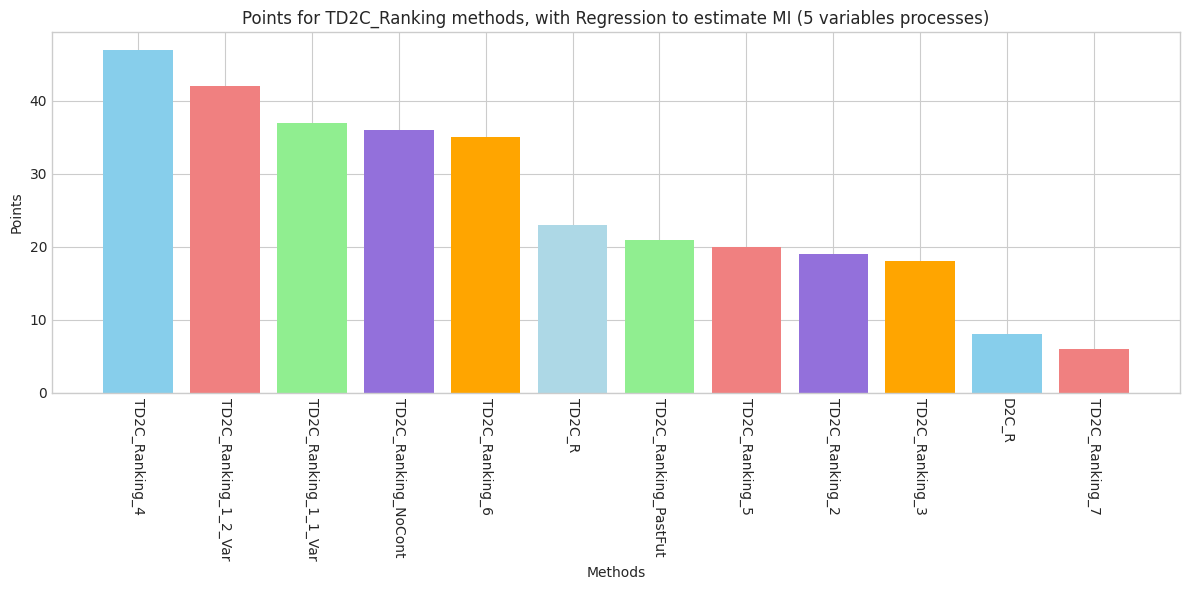

In [144]:
# # top 5 methods for roc-auc
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv')
df_r['points_r'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


# for precision
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_p['points_p'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# for recall
df_re = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_re['points_re'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# for f1
df_f = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')
df_f['points_f'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# merge the dataframes
df = pd.merge(df_r, df_p, on='method')
df = pd.merge(df, df_re, on='method')
df = pd.merge(df, df_f, on='method')

# sum the points for each method
df['points'] = df['points_r'] + df['points_p'] + df['points_re'] + df['points_f']

df = df.sort_values(by='points', ascending=False)

df = df.reset_index(drop=True)

# drop points_r, points_p, points_re, points_f columns
df = df.drop(columns=['points_r', 'points_p', 'points_re', 'points_f'])

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/top_td2c_methods_points.csv', index=False)

# plot the points for each method
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['points'], color=colors)
plt.xticks(rotation=-90)
plt.title('Points for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Points')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/top_td2c_methods_points.pdf')

plt.show()

In [145]:
# # top 5 methods for roc-auc
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv')
# df_r['points_r'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# multiply rocauc scores by 0.5
df_r['roc_auc'] = df_r['roc_auc'] * 0.5


# for precision
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
# df_p['points_p'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# multiply precision scores by 0.2
df_p['precision'] = df_p['precision'] * 0.2

# for recall
df_re = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
# df_re['points_re'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# multiply recall scores by 0.2
df_re['recall'] = df_re['recall'] * 0.2

# for f1
df_f = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')
# df_f['points_f'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# multiply f1 scores by 0.1
df_f['f1'] = df_f['f1'] * 0.1


# sum wheigthed scores
df_weithed = pd.concat([df_r['method'], df_r['roc_auc'], df_p['precision'], df_re['recall'], df_f['f1']], axis=1)
df_weithed['points'] = df_weithed.sum(axis=1)

df_weithed = df_weithed.sort_values(by='points', ascending=False)

df_weithed = df_weithed.reset_index(drop=True)

df_weithed = df_weithed.rename(columns={'roc_auc': 'ROC-AUC', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1'})

# save the dataframe to a csv file to folder

df_weithed.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/top_td2c_methods_points_weighted.csv', index=False)

df_weithed

method   ROC-AUC  Precision    Recall        F1    points
0         TD2C_Ranking_4  0.435536   0.101028  0.126620  0.052399  0.715583
1   TD2C_Ranking_1_2_Var  0.434121   0.098763  0.124751  0.050934  0.708569
2   TD2C_Ranking_1_1_Var  0.432390   0.095840  0.124135  0.050519  0.702883
3         TD2C_Ranking_5  0.432015   0.095612  0.123984  0.050408  0.702018
4         TD2C_Ranking_6  0.430725   0.095462  0.123385  0.049974  0.699546
5    TD2C_Ranking_NoCont  0.428708   0.094059  0.122245  0.046996  0.692008
6         TD2C_Ranking_3  0.422372   0.088766  0.115883  0.046197  0.673217
7   TD2C_Ranking_PastFut  0.420691   0.087879  0.112980  0.045642  0.667193
8                 TD2C_R  0.420220   0.086866  0.112756  0.044602  0.664444
9         TD2C_Ranking_2  0.417435   0.079188  0.112558  0.043102  0.652284
10        TD2C_Ranking_7  0.412379   0.077036  0.107414  0.042827  0.639656
11                 D2C_R  0.394004   0.070486  0.107381  0.038075  0.609946

In [136]:
# top 5 methods for roc-auc
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv')
# for precision
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
# for recall
df_re = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
# for f1
df_f = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# merge the dataframes
df = pd.merge(df_r, df_p, on='method')
df = pd.merge(df, df_re, on='method')
df = pd.merge(df, df_f, on='method')

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/td2c_methods_all_metrics_merged.csv', index=False)

df


method   roc_auc  precision    recall        f1
0         TD2C_Ranking_4  0.871073   0.493814  0.633098  0.523991
1   TD2C_Ranking_1_2_Var  0.868241   0.505141  0.616926  0.509343
2   TD2C_Ranking_1_1_Var  0.864779   0.470295  0.623757  0.504076
3         TD2C_Ranking_5  0.864029   0.385181  0.611225  0.428270
4         TD2C_Ranking_6  0.861450   0.479199  0.619920  0.499740
5    TD2C_Ranking_NoCont  0.857416   0.478059  0.620675  0.505187
6         TD2C_Ranking_3  0.844744   0.439395  0.562792  0.446016
7   TD2C_Ranking_PastFut  0.841383   0.443828  0.564901  0.456421
8                 TD2C_R  0.840440   0.477309  0.563781  0.469965
9         TD2C_Ranking_2  0.834870   0.434332  0.579413  0.461970
10        TD2C_Ranking_7  0.824758   0.352431  0.537068  0.380747
11                 D2C_R  0.788008   0.395939  0.536906  0.431024

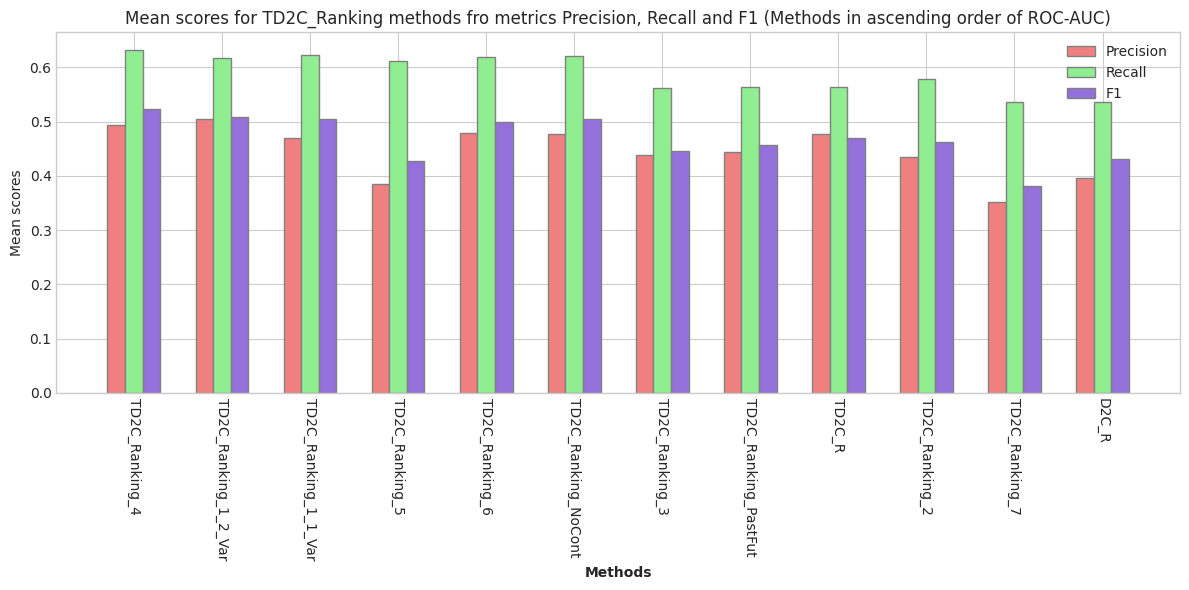

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrames
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv')
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_re = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_f = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# Merge the DataFrames on 'method'
df = pd.merge(df_r, df_p, on='method')
df = pd.merge(df, df_re, on='method')
df = pd.merge(df, df_f, on='method')

# Rename columns for clarity
df = df.rename(columns={'roc_auc': 'ROC-AUC', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1'})

# Number of methods
n_methods = len(df['method'])

# Positions of the bars on the x-axis
bar_width = 0.2
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting Barplot for methods with separated bars
plt.figure(figsize=(12, 6))
plt.bar(r1, df['Precision'], color='lightcoral', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, df['Recall'], color='lightgreen', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, df['F1'], color='mediumpurple', width=bar_width, edgecolor='grey', label='F1')

# Adding xticks
plt.xlabel('Methods', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_methods)], df['method'], rotation=-90)

plt.title('Mean scores for TD2C_Ranking methods fro metrics Precision, Recall and F1 (Methods in ascending order of ROC-AUC)')
plt.ylabel('Mean scores')
plt.legend(loc='upper right')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/top_td2c_methods_all_metrics_separated.pdf')

plt.show()